# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [5]:
prcAll = loadPrices('prices.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [6]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    for ma in [5]:
        for stock_i in range(nInst+1):
            log_return_df[f'forward_{ma}_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma)).shift(-ma)
            log_return_df[f'close_to_close (t-{ma})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma))
            
    # for ma in [1, 5]:
    #     for stock_i in range(nInst):
    #         for stock_j in range(stock_i+1, nInst):
    #             log_return_df[f'diff_forward_{ma}_{stock_i}_{stock_j}'] = log_return_df[f'forward_{ma}_{stock_i}'] - log_return_df[f'forward_{ma}_{stock_j}']
                # log_return_df[f'diff_close_to_close (t-{ma})(t0)_'+str(stock_i)+'_'+str(stock_j)] = log_return_df[f'close_to_close (t-{ma})(t0)_{stock_i}'] - log_return_df[f'close_to_close (t-{ma})(t0)_{stock_j}']

    return log_return_df

In [7]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    # for stock_id in range(nInst+1):
        # create lags
        # log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        
        # create MA
        # log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        # log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        # log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)

    log_return_df.rename(columns={stock_id:str(stock_id) for stock_id in range(nInst+1)}, inplace=True)
        
    
    return log_return_df

In [8]:
log_return_df = feature_engineer(prcAll)

In [9]:
# TRAIN_LENGTH = 250
# TEST_LENGTH = 50
# FIRST_TEST_DATE = 250

# features = ['close_to_close (t-5)(t0)']
# target_column = 'diff_forward_5_'

In [10]:
# todo: class this

def build_univariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)
        
    # build models
    model = OLS(y, X).fit()

    return model

def inference_univariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_univariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [11]:
def build_multivariate_linear_regression(log_return_df, target_stock, feature_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_multivariate_linear_regression(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[-1:]
    if target_stock == feature_stock:
        X = log_return_df[[f'{_}_{target_stock}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_multivariate(log_return_df, model, target_stock, feature_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]+[f'{_}_{feature_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    if target_stock == feature_stock:
        data = log_return_df[[f'{target_column}{target_stock}']+[f'{_}_{target_stock}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock}']
    X = data.drop(columns=[f'{target_column}{target_stock}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [12]:
# good_model_dict = defaultdict(dict)
# model_accuracy_dict = defaultdict(dict)
# model_features_dict = defaultdict(dict)

# for i in tqdm(range(NUM_STOCKS+1)):
#     for j in range(NUM_STOCKS+1):

#         ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH)
#         ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, FIRST_TEST_DATE, TRAIN_LENGTH)

#         if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
#             good_model_dict[i][j] = ma_model
#             model_features_dict[i][j] = features
#             model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

# final_model = defaultdict(dict)

# for stock_i in model_accuracy_dict:
#     top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
#     for stock_j, score in top_10:

#         if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
#             final_model[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

In [13]:
# for stock_i in final_model:
#     print(stock_i, final_model[stock_i].keys())

# Backtest

## Define Strategy

In [14]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(NUM_STOCKS+1):
            
            if BACKBONE_MODEL == 'univariate':
                ma_model = build_univariate_linear_regression(log_return_df, i, j, features, first_start_date, TRAIN_LENGTH)
                ma_y, ma_pred = predict_train_univariate(log_return_df, ma_model, i, j, features, first_start_date, TRAIN_LENGTH)
                if abs(ma_model.tvalues.values[0]) >= 2:
                    good_model_dict[i][j] = ma_model
                    model_features_dict[i][j] = features
                    model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

            elif BACKBONE_MODEL == 'multivariate':
                ma_model = build_multivariate_linear_regression(log_return_df, i, j, features, first_start_date, TRAIN_LENGTH)
                ma_y, ma_pred = predict_train_multivariate(log_return_df, ma_model, i, j, features, first_start_date, TRAIN_LENGTH)

                if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                    good_model_dict[i][j] = ma_model
                    model_features_dict[i][j] = features
                    model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

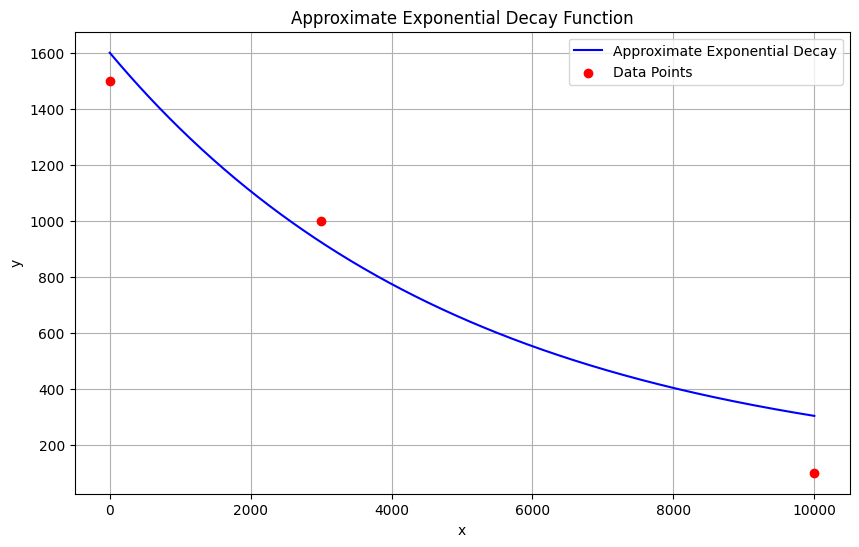

Manually chosen parameters:
a = 1500
b = 0.0002
c = 100


In [139]:
import numpy as np
import matplotlib.pyplot as plt

# Define the exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Manually chosen parameters
a = 1500  # Starting value at x=0
b = 0.0002  # Adjusted decay rate to decrease less rapidly
c = 100  # Asymptote value

# Generate x values for plotting the fitted function
x_values = np.linspace(0, 10000, 500)
y_values = exp_decay(x_values, a, b, c)

# Data points for reference
x_data = np.array([0, 3000, 10000])
y_data = np.array([1500, 1000, 100])

# Plot the data points and the fitted function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Approximate Exponential Decay', color='blue')
plt.scatter(x_data, y_data, color='red', zorder=5, label='Data Points')
plt.title('Approximate Exponential Decay Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print the manually chosen parameters
print("Manually chosen parameters:")
print("a =", a)
print("b =", b)
print("c =", c)


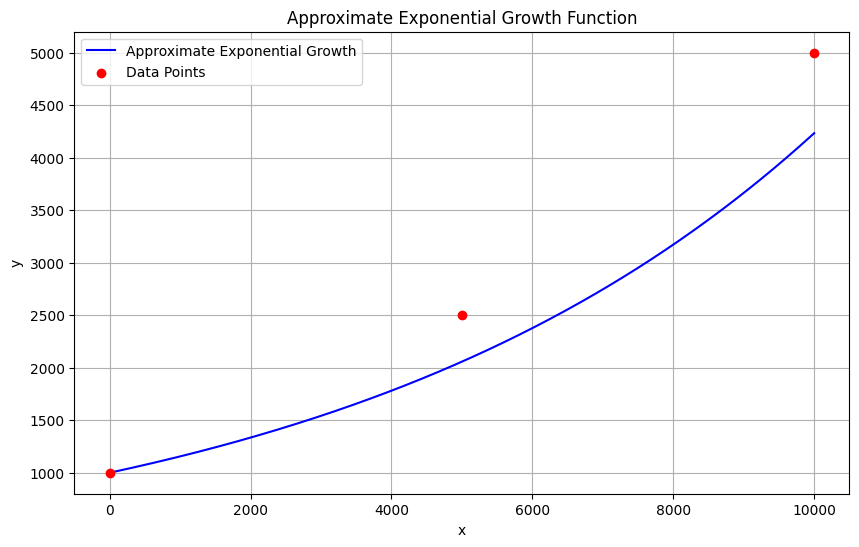

Manually chosen parameters:
a = 1000
b = 0.00014431
c = 0


In [194]:
# Manually chosen parameters
# Manually chosen parameters
a = 1000  # Starting value at x=0
b = 0.00014431  # Growth rate
c = 0  # No shift required for the given points

# Generate x values for plotting the fitted function
x_values = np.linspace(0, 10000, 500)
y_values = exp_growth(x_values, a, b, c)

# Data points for reference
x_data = np.array([0, 5000, 10000])
y_data = np.array([1000, 2500, 5000])

# Plot the data points and the fitted function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Approximate Exponential Growth', color='blue')
plt.scatter(x_data, y_data, color='red', zorder=5, label='Data Points')
plt.title('Approximate Exponential Growth Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print the manually chosen parameters
print("Manually chosen parameters:")
print("a =", a)
print("b =", b)
print("c =", c)

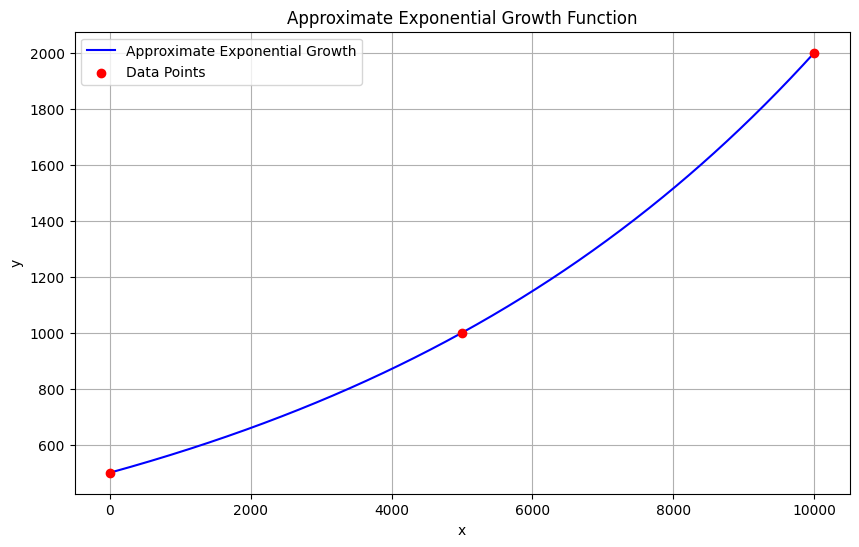

Manually chosen parameters:
a = 500
b = 0.00013863
c = 0


In [129]:
def exp_growth(x, a, b, c):
    return a * np.exp(b * x) + c

# Manually chosen parameters
a = 500  # Starting value at x=0
b = 0.00013863  # Growth rate
c = 0  # No shift required for the given points

# Generate x values for plotting the fitted function
x_values = np.linspace(0, 10000, 500)
y_values = exp_growth(x_values, a, b, c)

# Data points for reference
x_data = np.array([0, 5000, 10000])
y_data = np.array([500, 1000, 2000])

# Plot the data points and the fitted function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Approximate Exponential Growth', color='blue')
plt.scatter(x_data, y_data, color='red', zorder=5, label='Data Points')
plt.title('Approximate Exponential Growth Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# Print the manually chosen parameters
print("Manually chosen parameters:")
print("a =", a)
print("b =", b)
print("c =", c)


In [142]:
def exp_decay(x, a=1500, b=0.0002, c=100):        
    return a * np.exp(-b * x) + c

def exp_growth(x, a=500, b= 0.00013863, c=0):
    return a * np.exp(b * x) + c

In [200]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date, replicate_newPos, \
    buy_prices, sell_prices, take_cash, stop_loss, volatility_dict, signals
    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)
    
    if prcSoFar.shape[1] == START_DATE:
        buy_prices = {}
        sell_prices = {}

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        #TODO
        replicate_newPos = np.zeros(nInst)

        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)
        
        volatility_dict = defaultdict()
        for stock_i in range(50):
            volatility_dict[stock_i] = {'switch':False, 'count':0}
        
        # signals = np.zeros((nInst, 250))

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
        # old_model_dict = final_model_dict
    
    investment_size = 1000

    for stock_i in final_model_dict:
        
        ### Volatility based control strategy
        if volatility_dict[stock_i]['switch']:
            if volatility_dict[stock_i]['count'] > 0:
                volatility_dict[stock_i]['count'] -= 1
                # print(f"stock {stock_i} still closed, {volatility_dict[stock_i]['count']} days left")
                signals[stock_i, prcSoFar.shape[1]-START_DATE] = float(f"-10.{volatility_dict[stock_i]['count']}")
                continue
            else:
                volatility_dict[stock_i]['switch'] = False
                # print(f"stock {stock_i} opened")
                
        ten_day_return_signs = np.sign(log_return_df[f"{stock_i}"].iloc[-11:-1].reset_index(drop=True))
        
        change_sum = 0
        for i in range(1,10):
            change_sum += abs(ten_day_return_signs[i] - ten_day_return_signs[i-1])
        
        prediction_errors = 0
        if prcSoFar.shape[1]-START_DATE >= 10:              
            ten_day_predicted_returns = signals[stock_i, prcSoFar.shape[1]-START_DATE-10:prcSoFar.shape[1]-START_DATE]
            for i in range(10):
                if (ten_day_predicted_returns[i] == 1) or (ten_day_predicted_returns[i] == -1):
                    if ten_day_predicted_returns[i] != ten_day_return_signs[i]:
                        prediction_errors += 1
                    
        if change_sum >= 14 or prediction_errors >= 5:
            
            if not volatility_dict[stock_i]["switch"]: 
            # Turn on switch and shut stock for 3 days
                volatility_dict[stock_i]['switch'] = True
                volatility_dict[stock_i]['count'] = 2
                signals[stock_i, prcSoFar.shape[1]-START_DATE] = float(f"-10.{volatility_dict[stock_i]['count']}")
                continue
            # print(f"closed stock {stock_i}, {volatility_dict[stock_i]['count']} days left")
            
        ### Stop loss strategy
        three_day_return_signs = np.sign(log_return_df[f"{stock_i}"].iloc[-4:-1].reset_index(drop=True))
        
        currvalue = currentPos[stock_i]*prcSoFar[stock_i, -1]
        
        if sum(three_day_return_signs) == -2: # price dropped for 3 days
            if currvalue > 0: 
                # increase selling based on exponential growth
                investment_size = exp_growth(currvalue, a=1000, b=0.00014431, c=0)
                #investment_size = exp_growth(currvalue)
                currentPos[stock_i]-=investment_size/prcSoFar[stock_i, -1]
                continue
        
        elif sum(three_day_return_signs) == 2: # price increased for 3 days
            if currvalue < 0:
                # increase buying based on exponential growth
                investment_size = exp_growth(currvalue, a=1000, b=0.00014431, c=0)
                #investment_size = exp_growth(currvalue)
                currentPos[stock_i]+=investment_size/prcSoFar[stock_i, -1]
                continue
            
        
        # hundred_day_volatility = log_return_df[f'{stock_i}'].rolling(100).std().dropna().reset_index(drop=True).iloc[-1]
        # ten_day_volatility = log_return_df[f'{stock_i}'].rolling(10).std().dropna().reset_index(drop=True).iloc[-1]
        
        # if ten_day_volatility/hundred_day_volatility >= 1.2: 
        #     # The past ten days has been a relatively high volatility period. Take more cash, make less asset investments
        #     risk_exit_bar = 5000
        #     buy_take_cash = 1.005
        #     buy_stop_loss = 0.99
        #     sell_take_cash = 0.995
        #     sell_stop_loss = 1.01
        #     take_cash_size = 1000
        #     stop_loss_size = 500
        #     investment_size = 500
        
        # elif ten_day_volatility/hundred_day_volatility <= 1.2:
        #     # Normal time period with average volatility. Normal asset investments, take cash and stop loss only at extreme levels  
        #     risk_exit_bar = 8000
        #     buy_take_cash = 1.005
        #     buy_stop_loss = 0.995
        #     sell_take_cash = 0.995
        #     sell_stop_loss = 1.005
        #     take_cash_size = 500
        #     stop_loss_size = 500
        #     investment_size = 500
        
        # if currentPos[stock_i]*prcSoFar[stock_i, -1] > risk_exit_bar: #Start cash taking
        #     if prcSoFar[stock_i, -1]/np.mean(buy_prices[stock_i]) >= buy_take_cash:
        #     # if prcSoFar[stock_i, -1] - np.mean(buy_prices[stock_i]) > 0.1:
        #         currentPos[stock_i] -= take_cash_size/prcSoFar[stock_i, -1]
        #         take_cash[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(buy_prices[stock_i])
        #         # print("I took cash by selling 500")
        #         if stock_i in sell_prices.keys():
        #             sell_prices[stock_i].append(prcSoFar[stock_i, -1])
        #         else:       
        #             sell_prices[stock_i] = [prcSoFar[stock_i, -1]]
                
        #     elif prcSoFar[stock_i, -1]/np.mean(buy_prices[stock_i]) <= buy_stop_loss:
        #         currentPos[stock_i] -= stop_loss_size/prcSoFar[stock_i, -1]
        #         stop_loss[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(buy_prices[stock_i])
        #         if stock_i in sell_prices.keys():
        #             sell_prices[stock_i].append(prcSoFar[stock_i, -1])
        #         else:       
        #             sell_prices[stock_i] = [prcSoFar[stock_i, -1]]
            
        #     continue
        
        # elif currentPos[stock_i]*prcSoFar[stock_i, -1] < -risk_exit_bar: #Start cash taking 
        #     if prcSoFar[stock_i, -1]/np.mean(sell_prices[stock_i]) <= sell_take_cash:
        #     # if prcSoFar[stock_i, -1] - np.mean(sell_prices[stock_i]) < -0.1:
        #         currentPos[stock_i] += take_cash_size/prcSoFar[stock_i, -1]
        #         take_cash[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(sell_prices[stock_i])
        #         # print("I took cash by buying 500")
        #         if stock_i in buy_prices.keys():
        #             buy_prices[stock_i].append(prcSoFar[stock_i, -1])
        #         else:
        #             buy_prices[stock_i] = [prcSoFar[stock_i, -1]]
                
    
        #     elif prcSoFar[stock_i, -1]/np.mean(sell_prices[stock_i]) >= sell_stop_loss:
        #         currentPos[stock_i] += stop_loss_size/prcSoFar[stock_i, -1]
        #         stop_loss[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(sell_prices[stock_i])
        #         if stock_i in buy_prices.keys():
        #             buy_prices[stock_i].append(prcSoFar[stock_i, -1])
        #         else:
        #             buy_prices[stock_i] = [prcSoFar[stock_i, -1]]
            
        #     continue
        
        stock_i_predictions_list = []
        for stock_j in final_model_dict[stock_i]:
            if BACKBONE_MODEL == 'univariate':
                stock_i_predictions_list.append(inference_univariate_linear_regression(log_return_df,
                                       final_model_dict[stock_i][stock_j],
                                       stock_i,
                                       stock_j,
                                       model_features_dict[stock_i][stock_j],
                                       first_start_date,
                                       TRAIN_LENGTH))
            elif BACKBONE_MODEL == 'multivariate':
                stock_i_predictions_list.append(inference_multivariate_linear_regression(log_return_df,
                                        final_model_dict[stock_i][stock_j],
                                        stock_i,
                                        stock_j,
                                        model_features_dict[stock_i][stock_j],
                                        first_start_date,
                                        TRAIN_LENGTH))
        stock_i_prediction = np.sum([np.sign(x) for x in stock_i_predictions_list])

        signals[stock_i, prcSoFar.shape[1]-START_DATE] = int(np.sign(stock_i_prediction))
        
        if stock_i in buy_prices.keys():
            take_cash[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(buy_prices[stock_i])
        if stock_i in sell_prices.keys():
            stop_loss[stock_i, prcSoFar.shape[1]-START_DATE] = np.mean(sell_prices[stock_i])

        if stock_i_prediction > 0 and abs(currvalue) < dlrPosLimit:
        
            if currvalue >= 0:
                investment_size = exp_decay(currvalue)
            else:
                investment_size = exp_growth(abs(currvalue))
                
            currentPos[stock_i]+=investment_size/prcSoFar[stock_i, -1]

            if stock_i in buy_prices.keys():
                buy_prices[stock_i].append(prcSoFar[stock_i, -1])
            else:
                buy_prices[stock_i] = [prcSoFar[stock_i, -1]]
            
                
        elif stock_i_prediction < -0 and currvalue > -dlrPosLimit:
            if currvalue <= 0:
                investment_size = exp_decay(abs(currvalue))
            else:
                investment_size = exp_growth(currvalue)
                
            currentPos[stock_i]-=investment_size/prcSoFar[stock_i, -1]
            
            if stock_i in sell_prices.keys():
                sell_prices[stock_i].append(prcSoFar[stock_i, -1])
            else:       
                sell_prices[stock_i] = [prcSoFar[stock_i, -1]]
        else:
            no_signal += 1
        total_signals += 1

        replicate_newPos[stock_i] = currentPos[stock_i]
        replicate_newPos[stock_i] = np.clip(replicate_newPos[stock_i], int(-10000/prcSoFar[stock_i, -1]), int(10000/prcSoFar[stock_i, -1]))


    return currentPos

## Run

In [70]:
BACKBONE_MODEL = 'multivariate'

TRAIN_LENGTH = 250
TEST_LENGTH = 250

features = ['close_to_close (t-5)(t0)']
target_column = ''

In [199]:
START_DATE = 250
prcAll = loadPrices('prices.txt')
signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])
take_cash = np.zeros([50, 251])
stop_loss = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])
no_signal = 0
total_signals = 0

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -38.40 todayPL: $-38.40 $-traded: 38400 return: -0.00100
Day 251 value: -80.00 todayPL: $-41.60 $-traded: 67886 return: -0.00118
Day 252 value: -49.76 todayPL: $30.24 $-traded: 88282 return: -0.00056
Day 253 value: -120.67 todayPL: $-70.90 $-traded: 107314 return: -0.00112
Day 254 value: -376.73 todayPL: $-256.07 $-traded: 126612 return: -0.00298
Day 255 value: -414.97 todayPL: $-38.24 $-traded: 145425 return: -0.00285
Day 256 value: -414.48 todayPL: $0.49 $-traded: 162708 return: -0.00255
Day 257 value: -446.90 todayPL: $-32.42 $-traded: 180784 return: -0.00247
Day 258 value: -605.99 todayPL: $-159.09 $-traded: 198959 return: -0.00305
Day 259 value: -516.62 todayPL: $89.37 $-traded: 216618 return: -0.00238
Day 260 value: -497.27 todayPL: $19.35 $-traded: 224922 return: -0.00221
Day 261 value: -126.13 todayPL: $371.14 $-traded: 233240 return: -0.00054
Day 262 value: -65.87 todayPL: $60.26 $-traded: 242020 return: -0.00027
Day 263 value: 18.89 todayPL: $84.76 $-traded: 25

In [201]:
START_DATE = 500
prcAll = loadPrices('prices_r1.txt')
signals = np.zeros([50, 251])
take_cash = np.zeros([50, 251])
stop_loss = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])
no_signal = 0
total_signals = 0

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 500 value: -44.80 todayPL: $-44.80 $-traded: 44800 return: -0.00100
Day 501 value: -110.19 todayPL: $-65.39 $-traded: 73144 return: -0.00151
Day 502 value: -146.40 todayPL: $-36.21 $-traded: 97464 return: -0.00150
Day 503 value: -30.57 todayPL: $115.83 $-traded: 121516 return: -0.00025
Day 504 value: -47.74 todayPL: $-17.17 $-traded: 139348 return: -0.00034
Day 505 value: 24.53 todayPL: $72.27 $-traded: 157796 return: 0.00016
Day 506 value: -46.65 todayPL: $-71.19 $-traded: 177590 return: -0.00026
Day 507 value: -12.56 todayPL: $34.09 $-traded: 198400 return: -0.00006
Day 508 value: -103.59 todayPL: $-91.03 $-traded: 222260 return: -0.00047
Day 509 value: -390.41 todayPL: $-286.82 $-traded: 243389 return: -0.00160
Day 510 value: -431.01 todayPL: $-40.61 $-traded: 254078 return: -0.00170
Day 511 value: -434.61 todayPL: $-3.60 $-traded: 262679 return: -0.00165
Day 512 value: -485.87 todayPL: $-51.26 $-traded: 269084 return: -0.00181
Day 513 value: -451.11 todayPL: $34.76 $-traded: 28

In [185]:
const = 249
df_rows = []

for STOCK in range(nInst):

    for i in range(251):
        df_rows.append({
            'Signal': signals[STOCK][i],
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'Average buy price': take_cash[STOCK][i],
            "Average sell price": stop_loss[STOCK][i],
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
audit_df.to_excel('audit_table_250_volatility_switch_model.xlsx')

In [19]:
# START_DATE = 500

# signals = np.zeros([50, 251])
# positions = np.zeros([50, 251])
# returns = np.zeros([50, 251])

# values_array = np.zeros([50, 251])
# cash_array = np.zeros([50, 251])
# todayPL_array = np.zeros([50, 251])

# commRate = 0.0010
# dlrPosLimit = 10000

# nInst = 50
# currentPos = np.zeros(nInst)

# def calcPL(prcHist):
#     global pll
#     cash = 0
#     curPos = np.zeros(nInst)
#     totDVolume = 0
#     totDVolumeSignal = 0
#     totDVolumeRandom = 0
#     value = 0
#     todayPLL = []
#     (_, nt) = prcHist.shape
#     for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
#         prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
#         newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
#         curPrices = prcHistSoFar[:, -1]
#         posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
#         newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
#         deltaPos = newPos - curPos # t0 change position
        
#         positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
#         dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
#         dvolume = np.sum(dvolumes)
#         totDVolume += dvolume 
#         comm = dvolume * commRate # t0 commission
#         cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

#         cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
#               else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

#         curPos = np.array(newPos) 
#         posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
#         todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
#         if t != START_DATE+250:
#             returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
#             todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
#                 else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

#         todayPLL.append(todayPL) 
#         value = cash + posValue

#         values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

#         ret = 0.0
#         if (totDVolume > 0):
#             ret = value / totDVolume
#         print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
#               (t, value, todayPL, totDVolume, ret))
#     pll = np.array(todayPLL)
#     (plmu, plstd) = (np.mean(pll), np.std(pll))
#     annSharpe = 0.0
#     if (plstd > 0):
#         annSharpe = np.sqrt(250) * plmu / plstd
#     return (plmu, ret, plstd, annSharpe, totDVolume)


# (meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
# score = meanpl - 0.1*plstd
# print("=====")
# print("mean(PL): %.1lf" % meanpl)
# print("return: %.5lf" % ret)
# print("StdDev(PL): %.2lf" % plstd)
# print("annSharpe(PL): %.2lf " % sharpe)
# print("totDvolume: %.0lf " % dvol)
# print("Score: %.2lf" % score)

In [20]:
# START_DATE = 750

# signals = np.zeros([50, 251])
# positions = np.zeros([50, 251])
# returns = np.zeros([50, 251])

# values_array = np.zeros([50, 251])
# cash_array = np.zeros([50, 251])
# todayPL_array = np.zeros([50, 251])

# commRate = 0.0010
# dlrPosLimit = 10000

# nInst = 50
# currentPos = np.zeros(nInst)

# def calcPL(prcHist):
#     global pll
#     cash = 0
#     curPos = np.zeros(nInst)
#     totDVolume = 0
#     totDVolumeSignal = 0
#     totDVolumeRandom = 0
#     value = 0
#     todayPLL = []
#     (_, nt) = prcHist.shape
#     for t in range(750, 1001): # t will go from 250 to 500 (251 numbers)
#         prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
#         newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
#         curPrices = prcHistSoFar[:, -1]
#         posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
#         newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
#         deltaPos = newPos - curPos # t0 change position
        
#         positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
#         dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
#         dvolume = np.sum(dvolumes)
#         totDVolume += dvolume 
#         comm = dvolume * commRate # t0 commission
#         cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

#         cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
#               else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

#         curPos = np.array(newPos) 
#         posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
#         todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
#         if t != START_DATE+250:
#             returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
#             todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
#                 else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

#         todayPLL.append(todayPL) 
#         value = cash + posValue

#         values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

#         ret = 0.0
#         if (totDVolume > 0):
#             ret = value / totDVolume
#         print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
#               (t, value, todayPL, totDVolume, ret))
#     pll = np.array(todayPLL)
#     (plmu, plstd) = (np.mean(pll), np.std(pll))
#     annSharpe = 0.0
#     if (plstd > 0):
#         annSharpe = np.sqrt(250) * plmu / plstd
#     return (plmu, ret, plstd, annSharpe, totDVolume)


# (meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
# score = meanpl - 0.1*plstd
# print("=====")
# print("mean(PL): %.1lf" % meanpl)
# print("return: %.5lf" % ret)
# print("StdDev(PL): %.2lf" % plstd)
# print("annSharpe(PL): %.2lf " % sharpe)
# print("totDvolume: %.0lf " % dvol)
# print("Score: %.2lf" % score)

# Evaluation

In [21]:
# returns_flatten = returns[:250].flatten()
# signals_flatten = signals[:250].flatten()

# buckets = {}
# for i in range(-51, 51, 5):
#     buckets[(i, i+1)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i and signals_flatten[j] < i+1]
# buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# # Extract the mid-point of each bucket range and the mean returns
# bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
# bucket_means = [value for key, value in buckets]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(bucket_midpoints, bucket_means, color='blue')
# plt.xlabel('Signal Buckets Midpoints')
# plt.ylabel('Mean Returns')
# plt.axvline(x=0, color='r', linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
# plt.title('Mean Returns per Signal Bucket')
# plt.grid(True)
# plt.show()

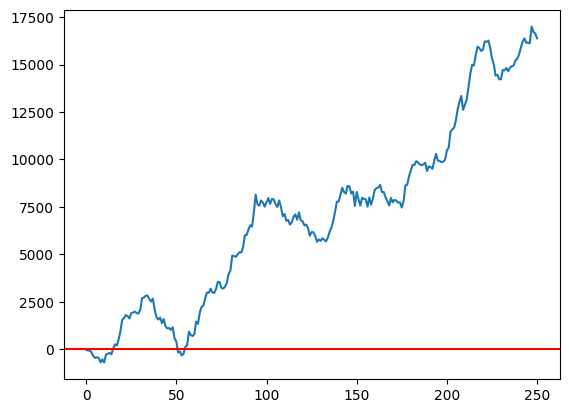

In [22]:
plt.plot(np.cumsum(pll))
plt.axhline(y=0, color='r', linestyle='-')

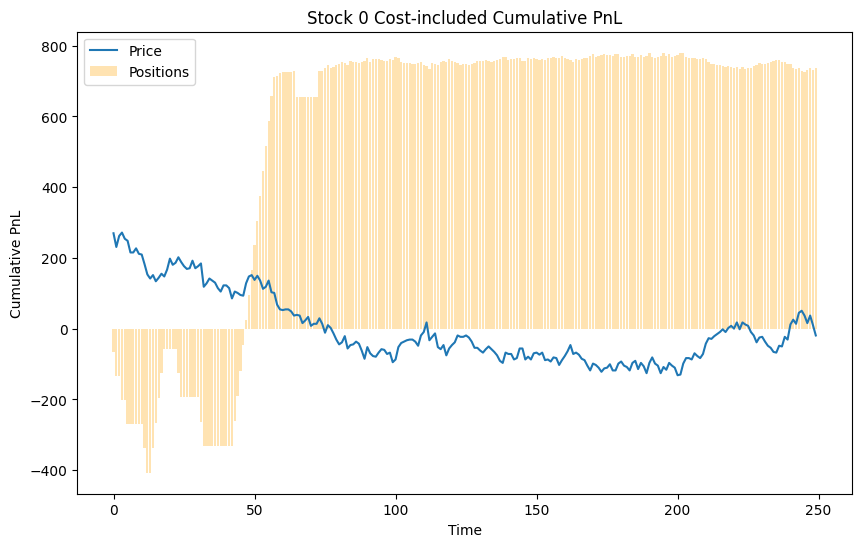

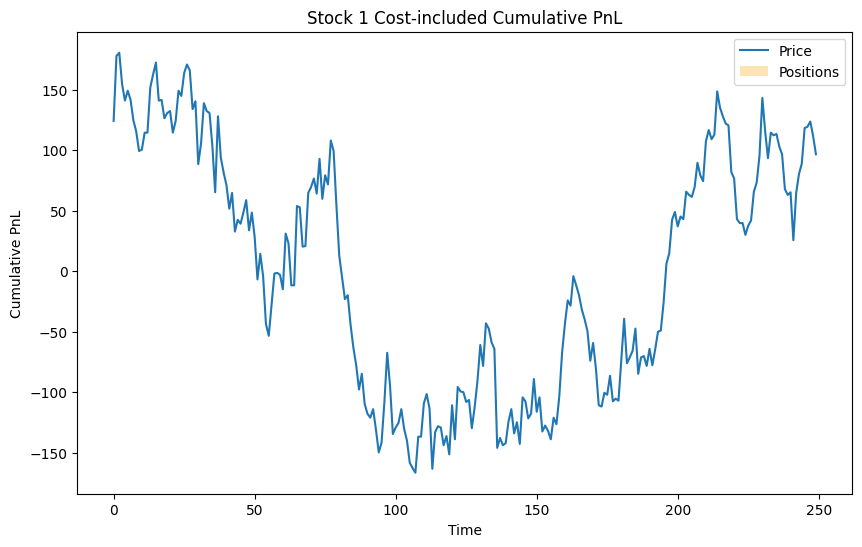

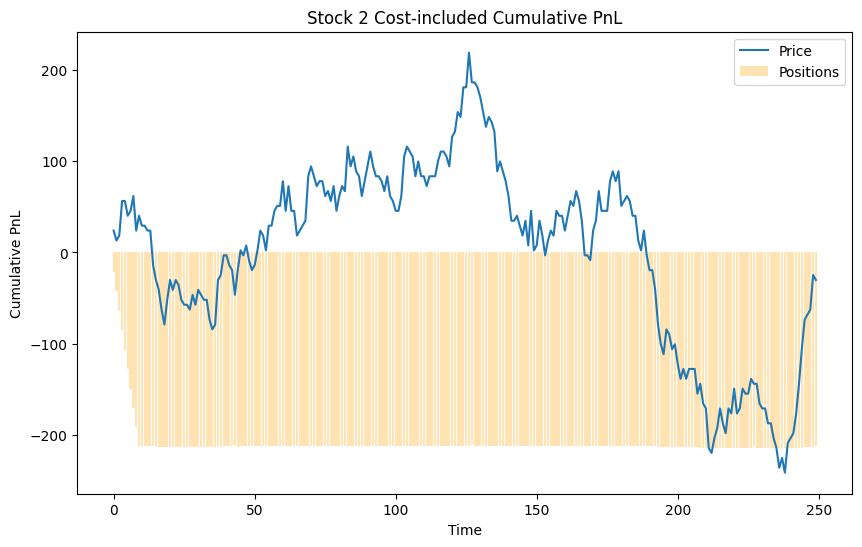

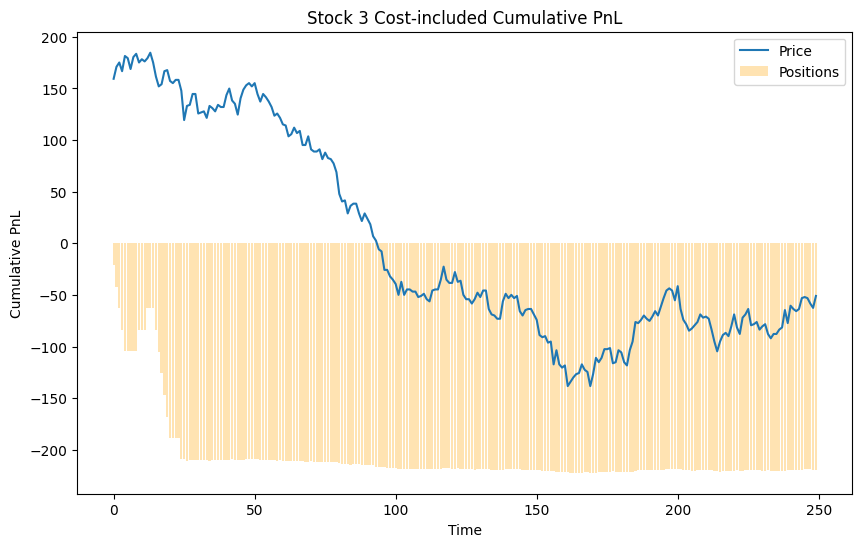

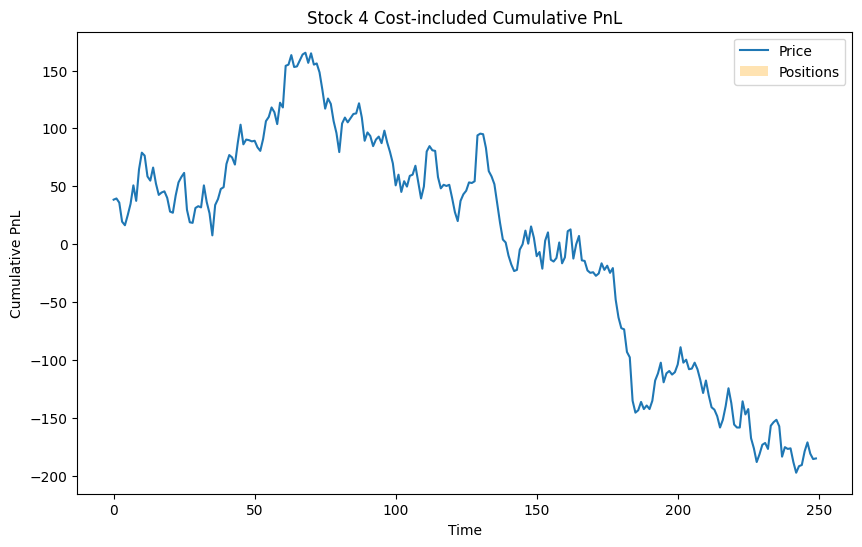

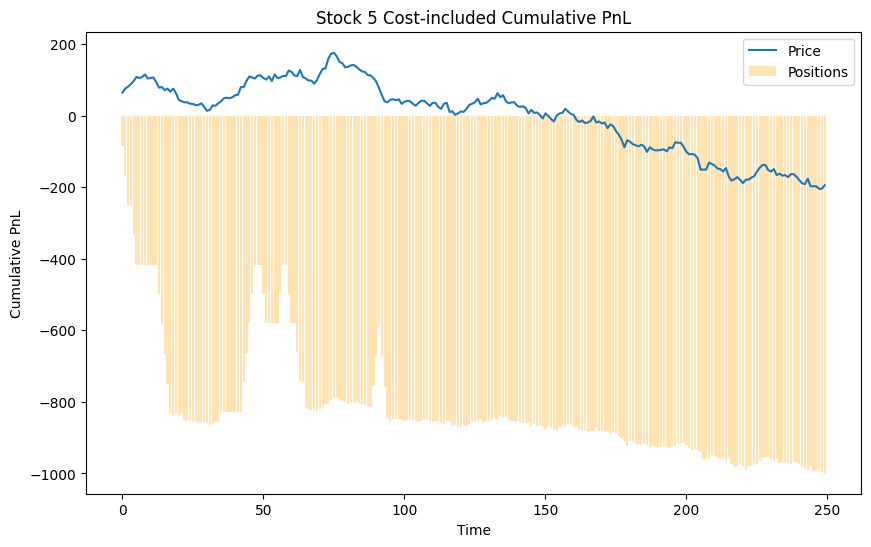

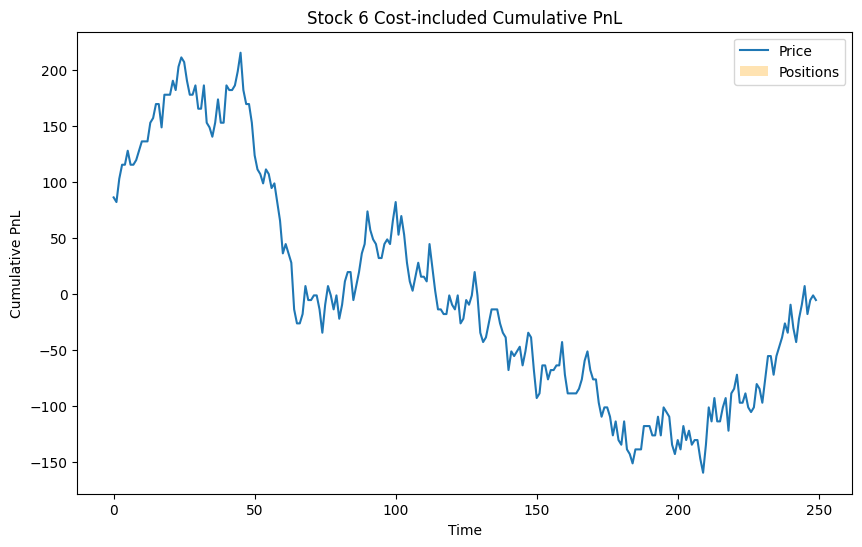

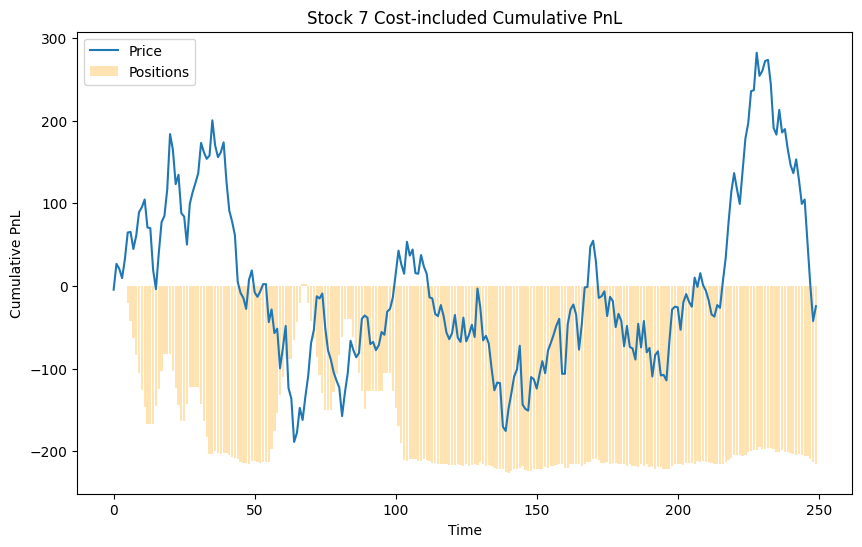

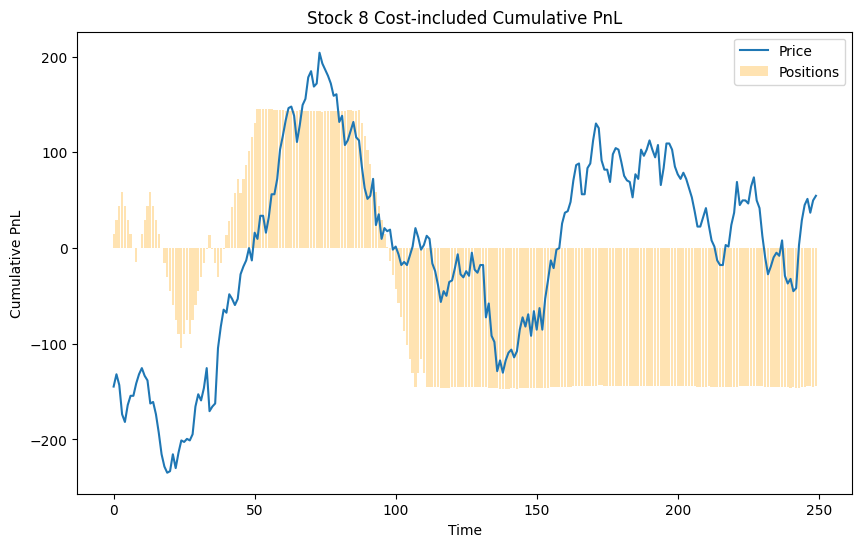

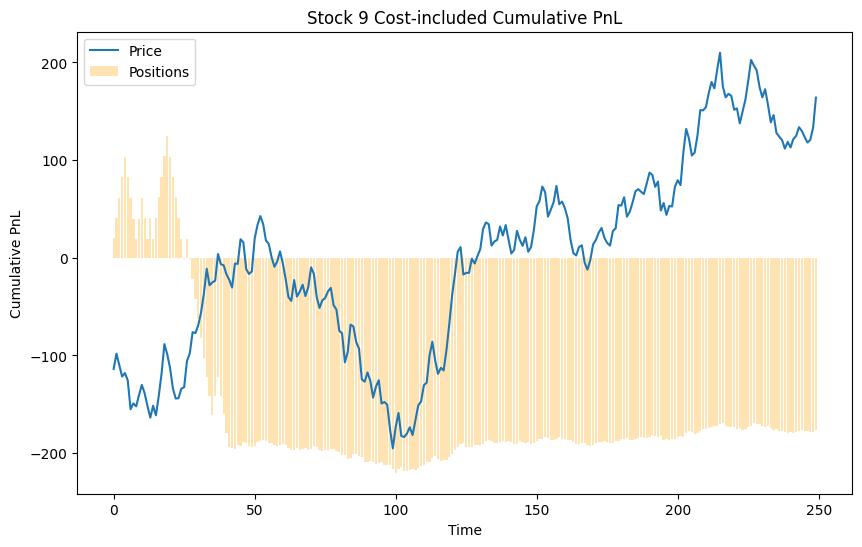

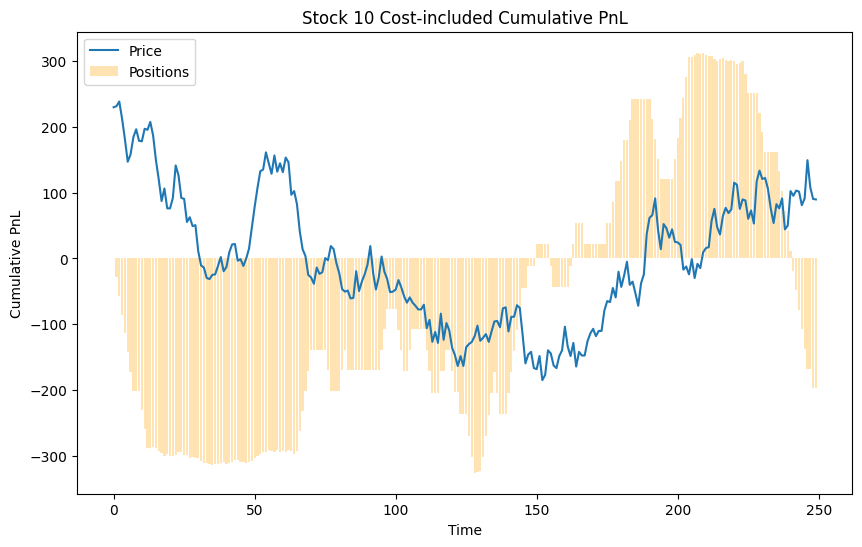

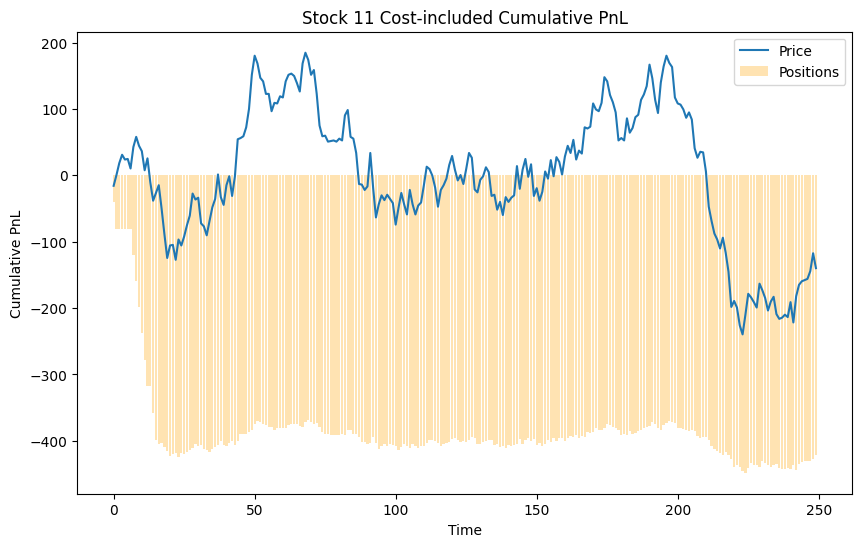

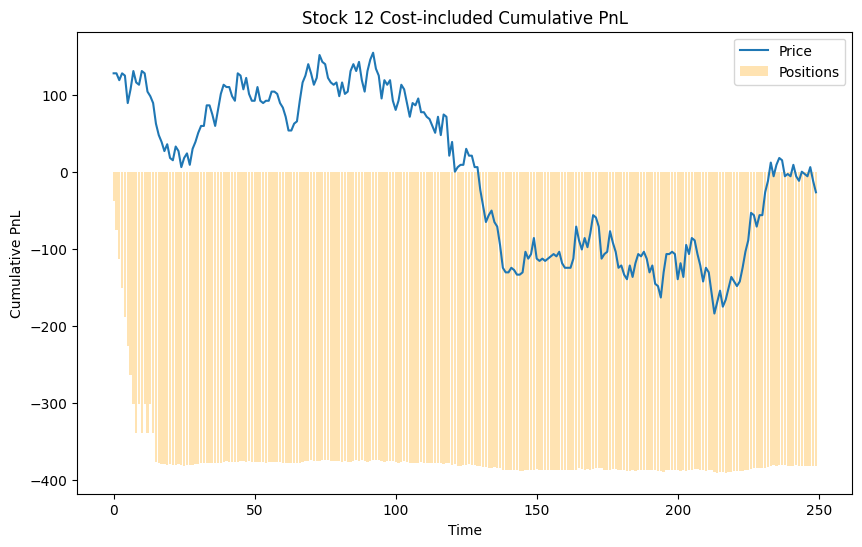

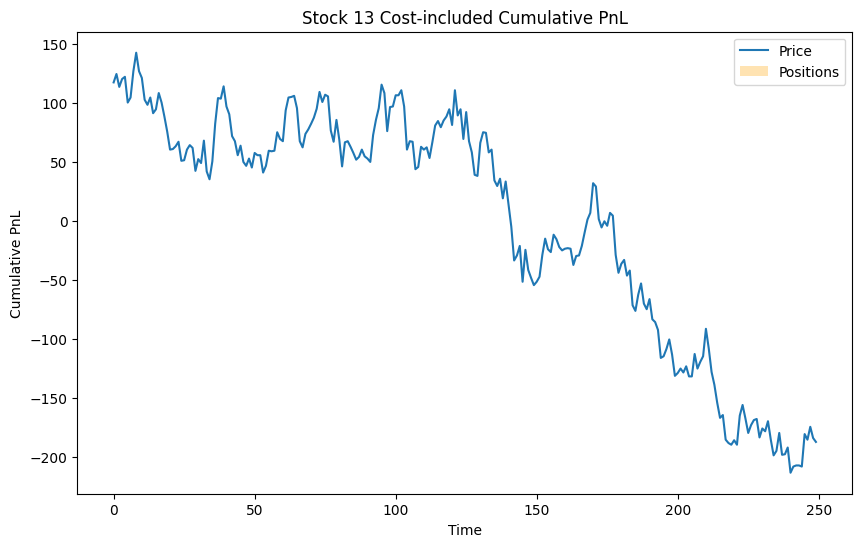

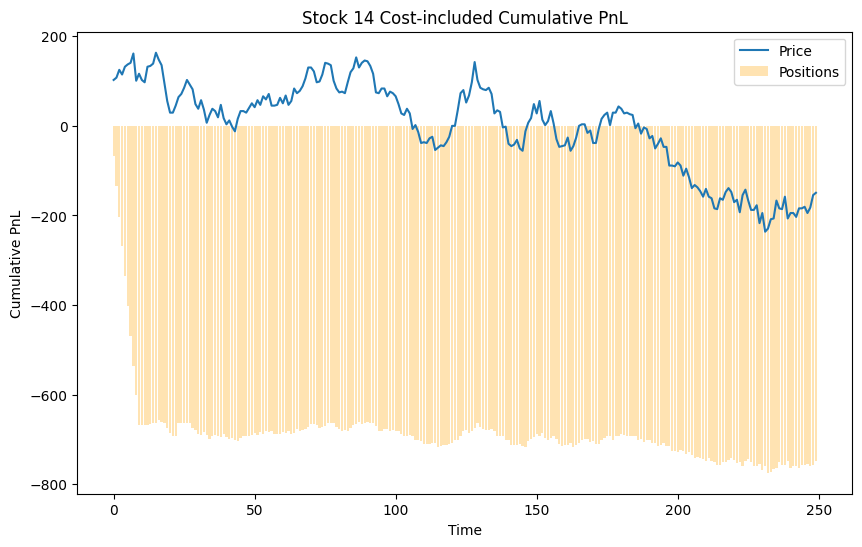

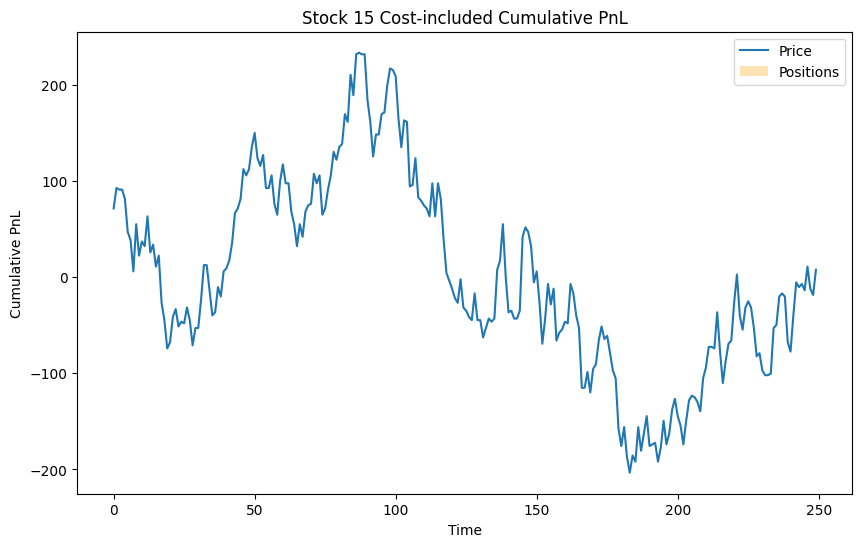

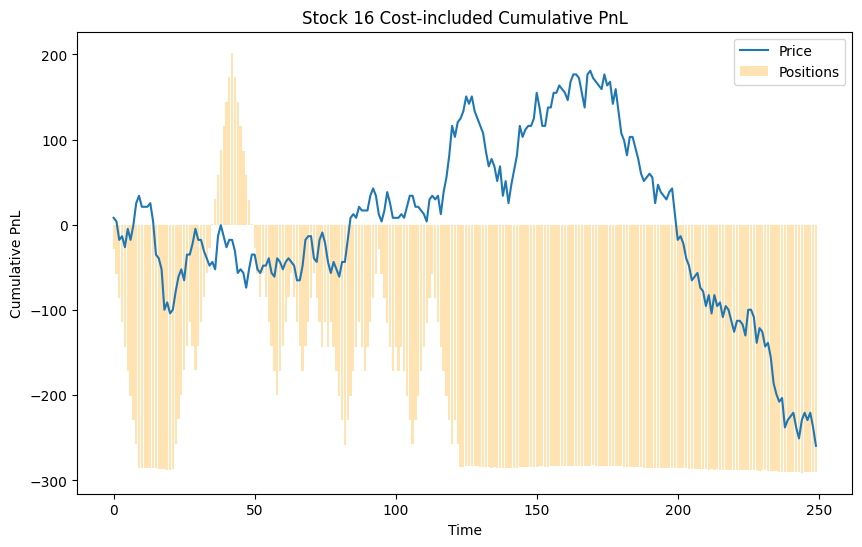

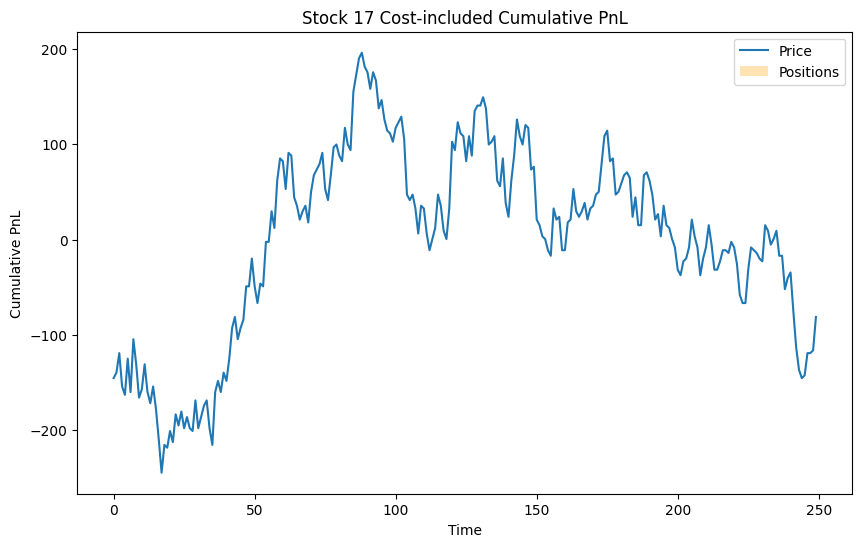

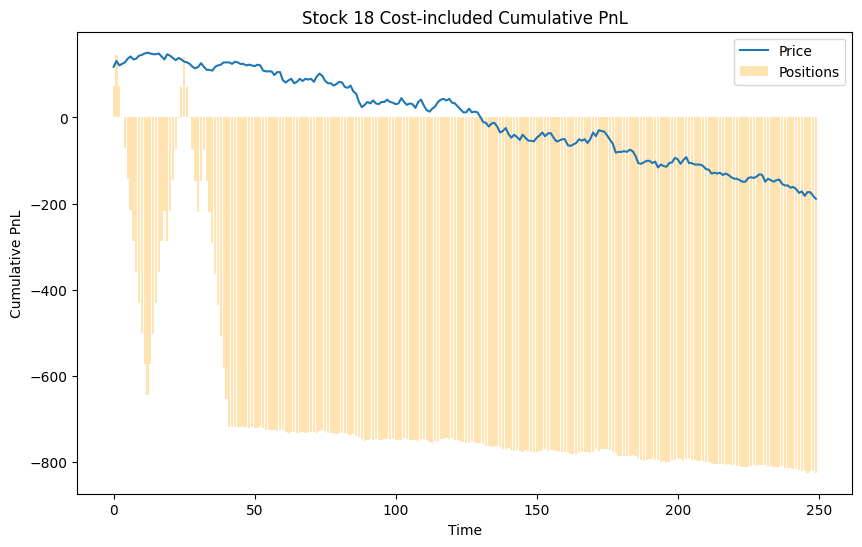

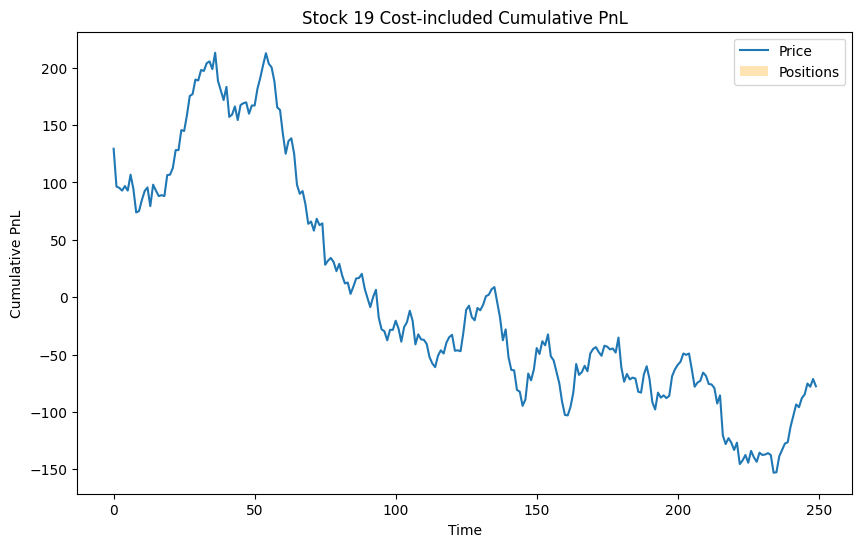

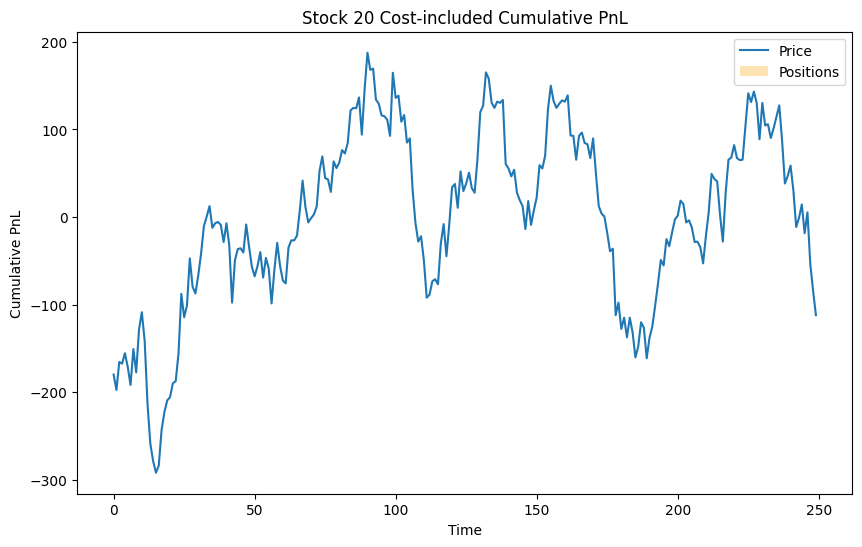

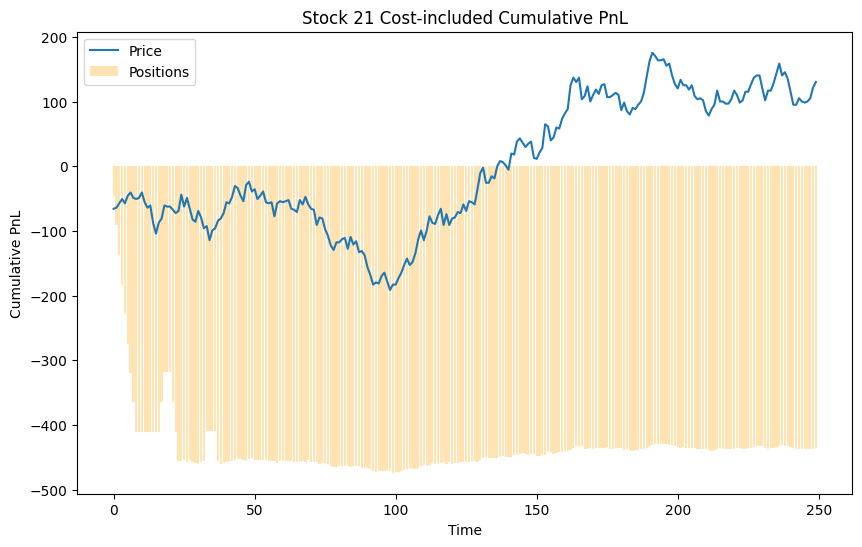

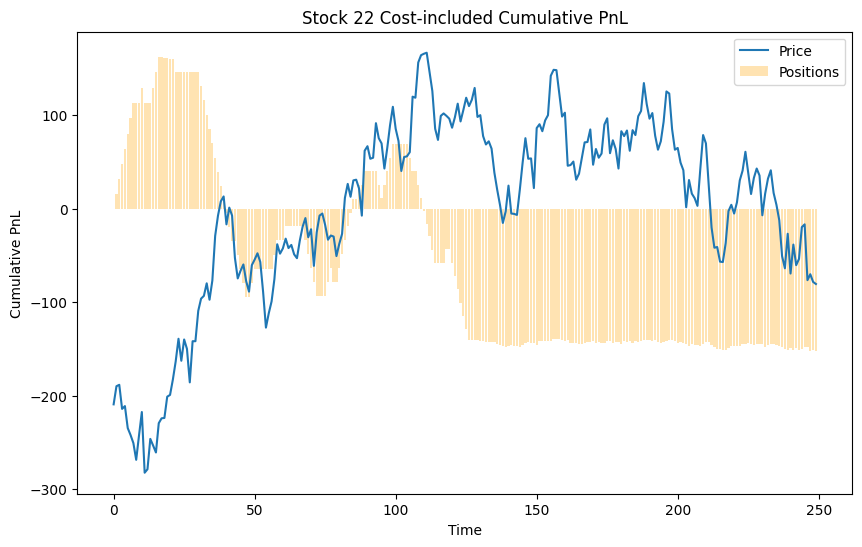

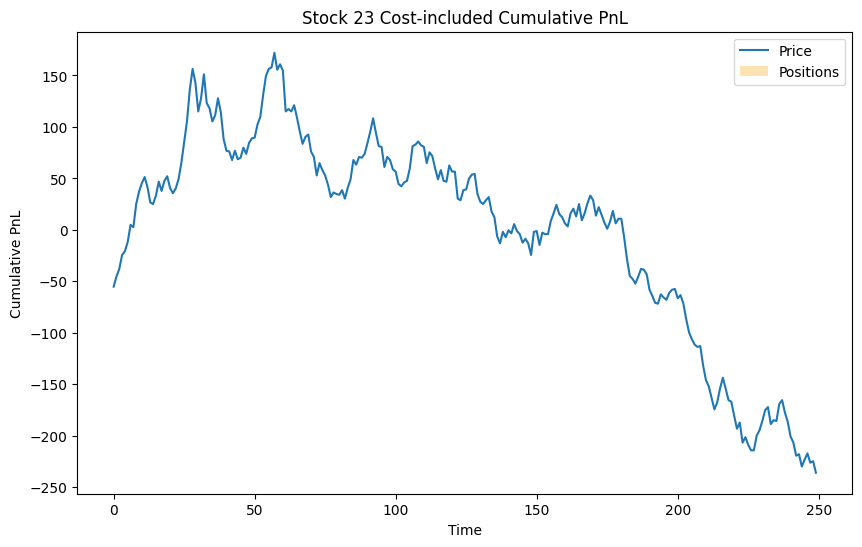

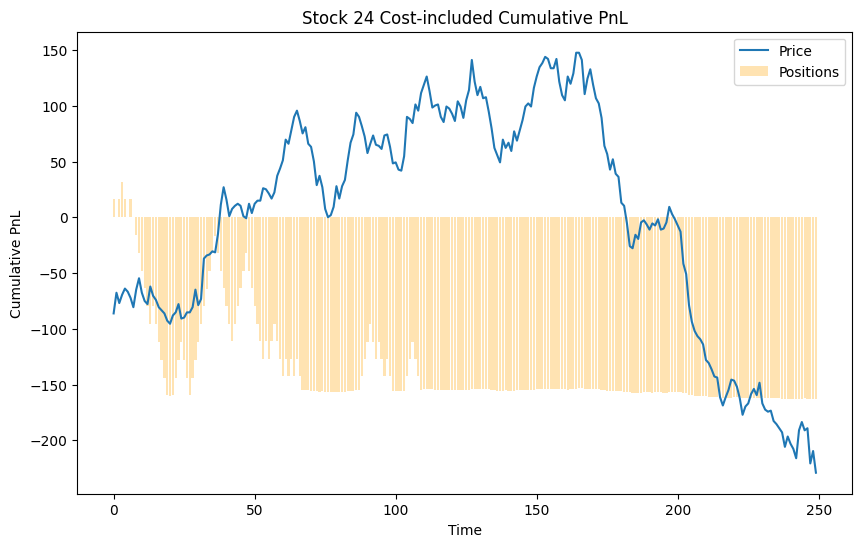

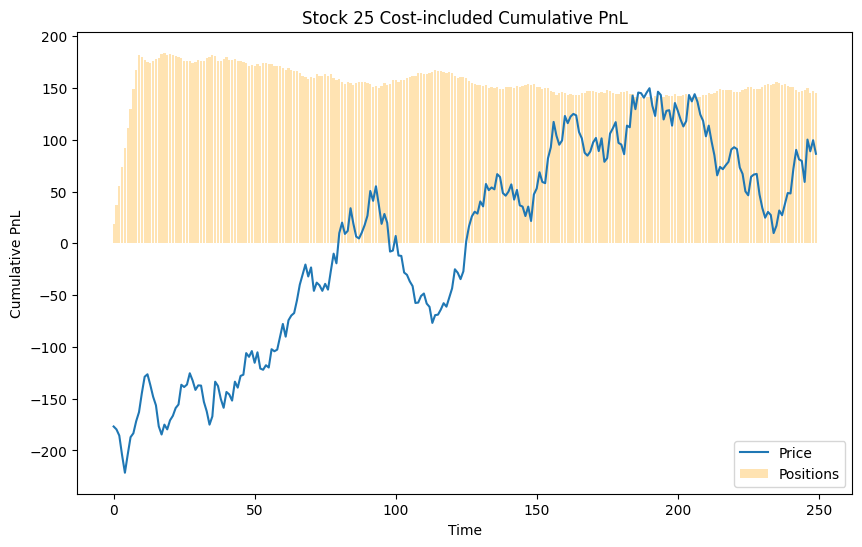

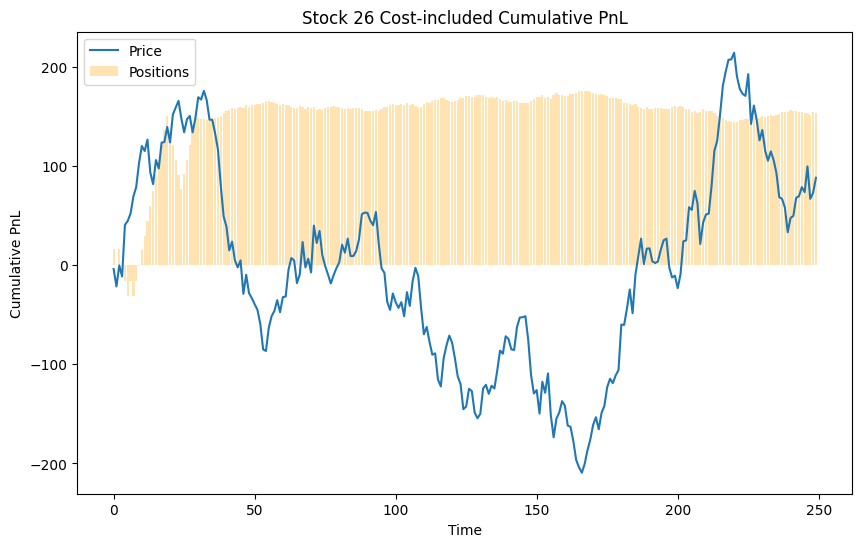

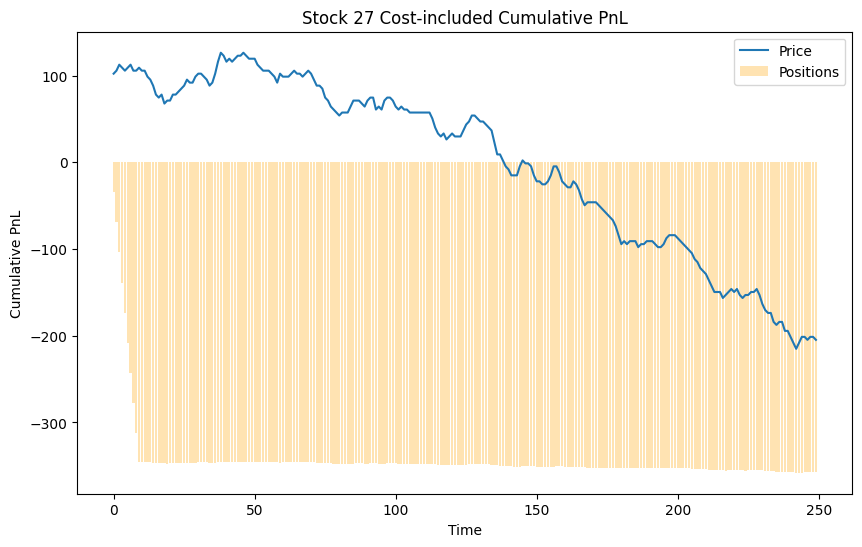

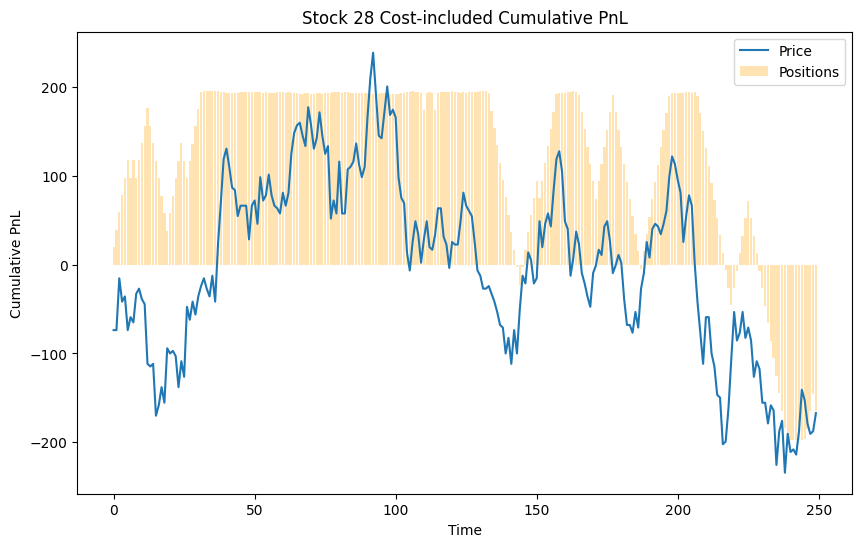

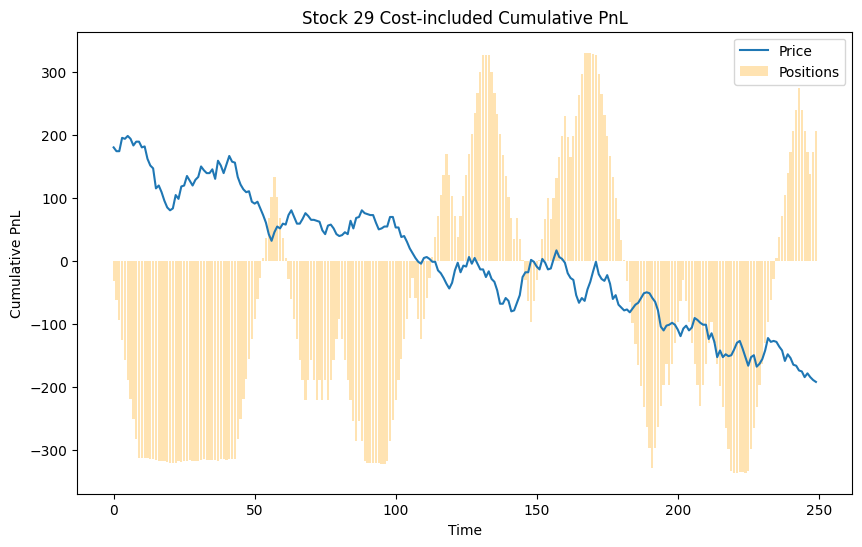

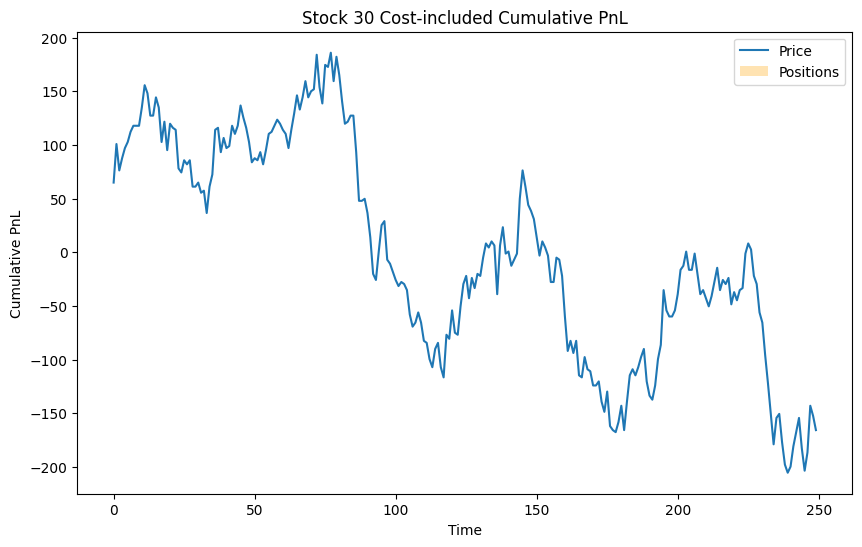

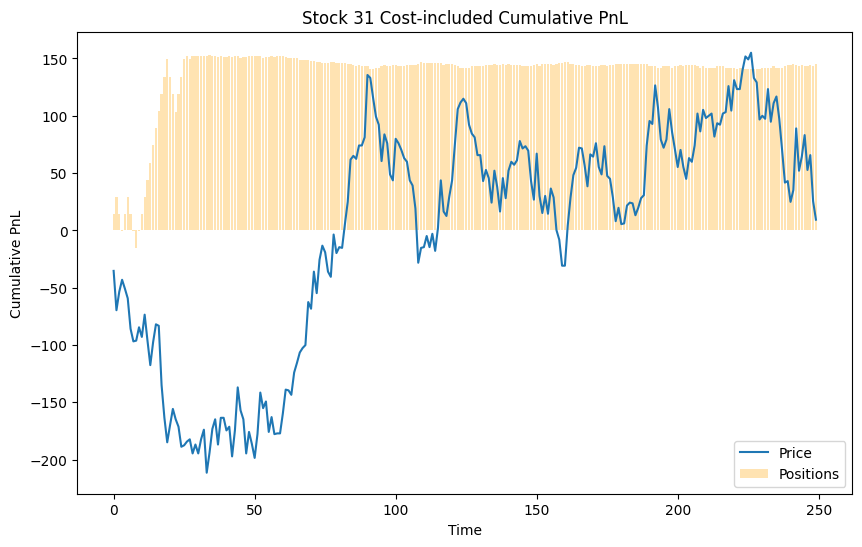

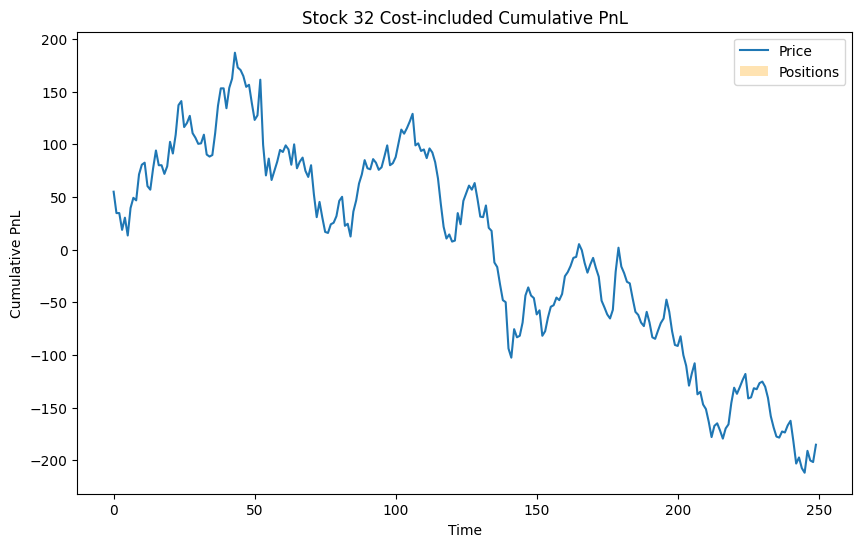

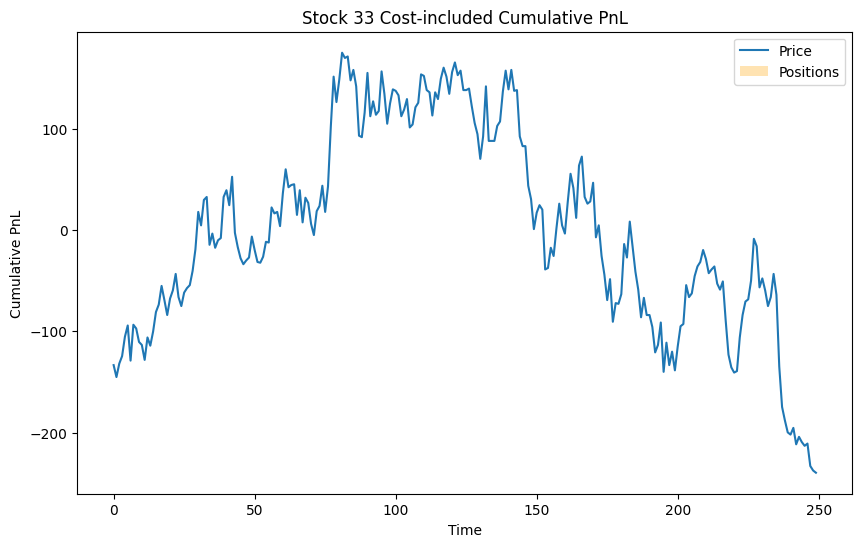

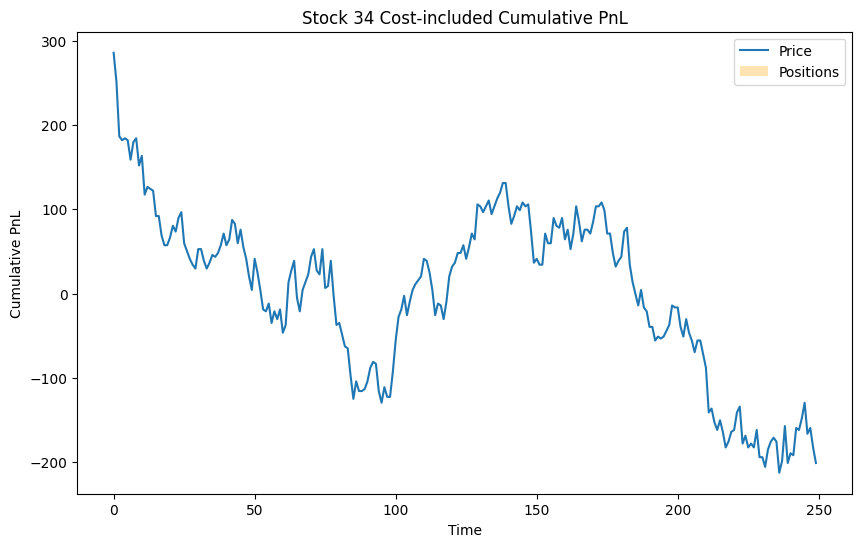

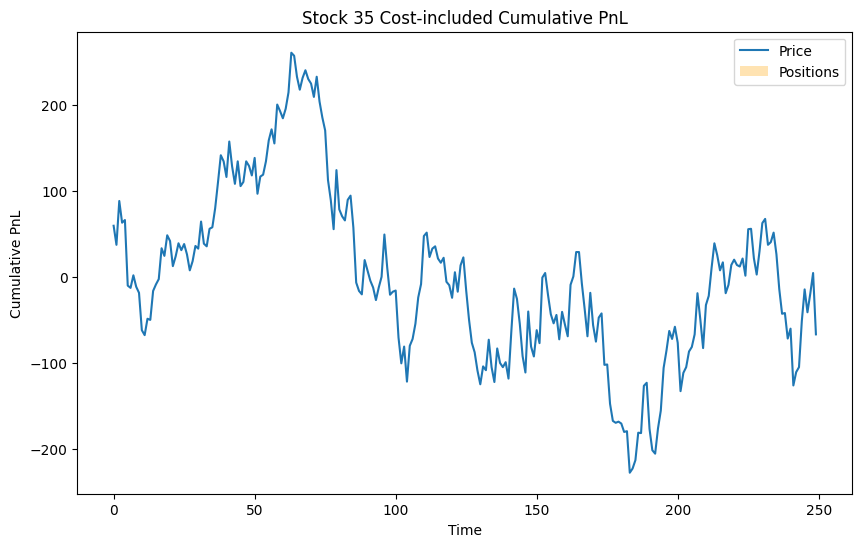

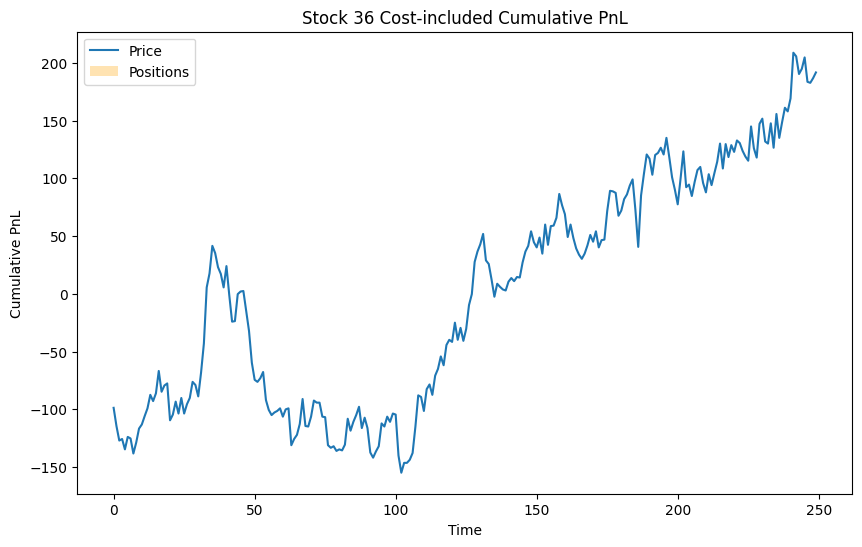

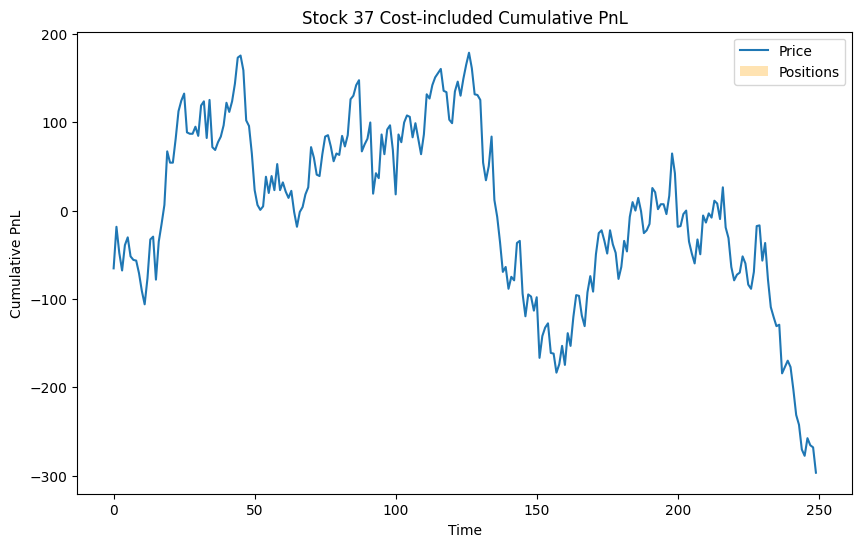

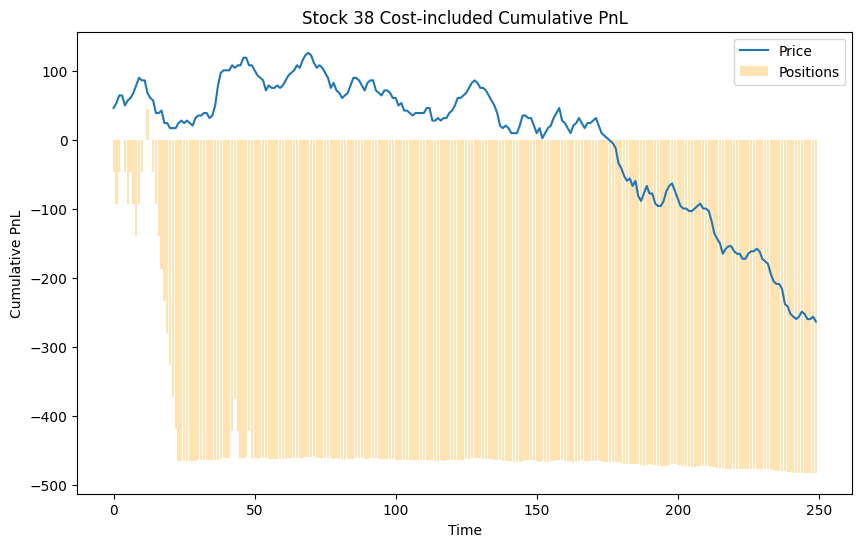

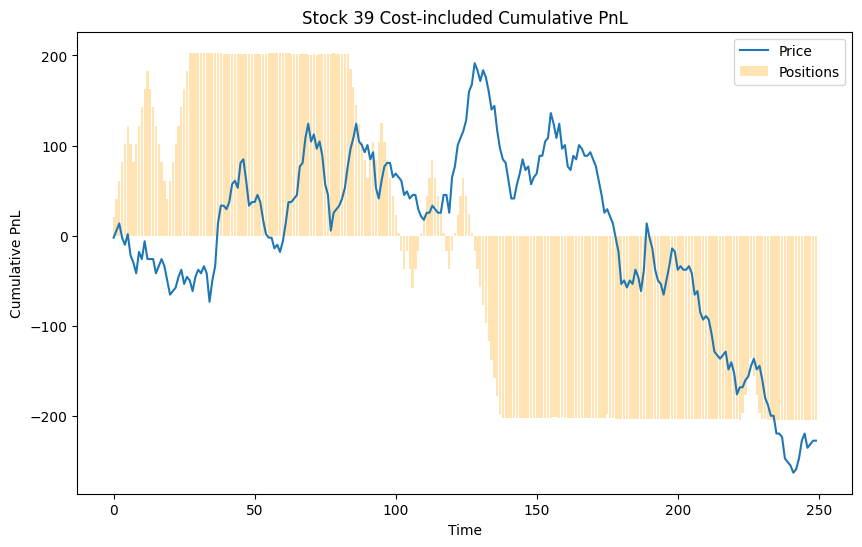

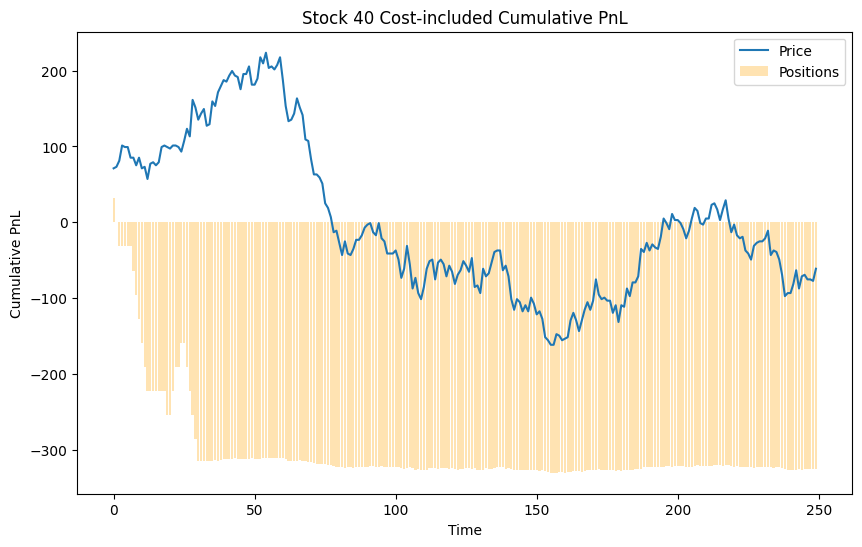

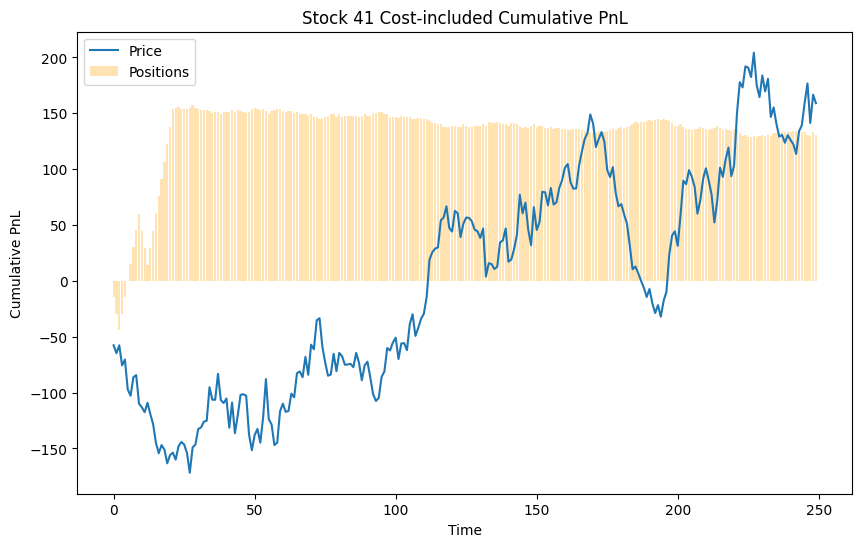

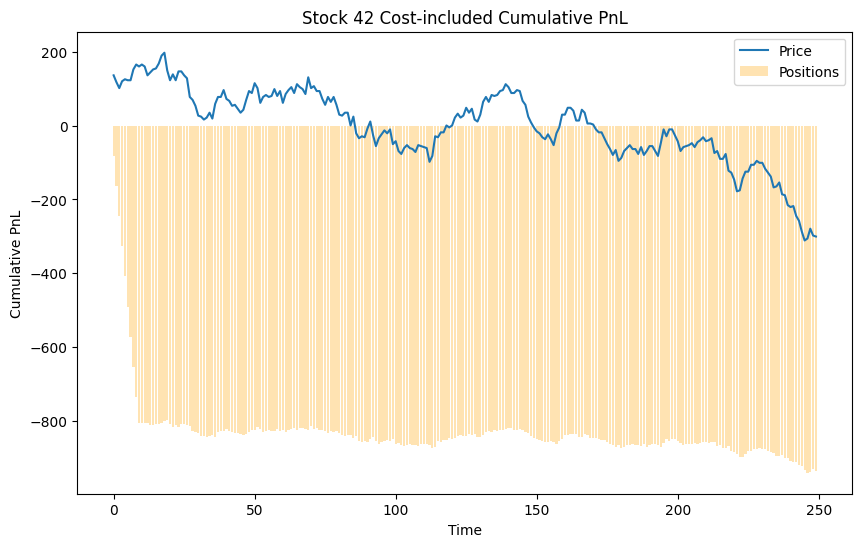

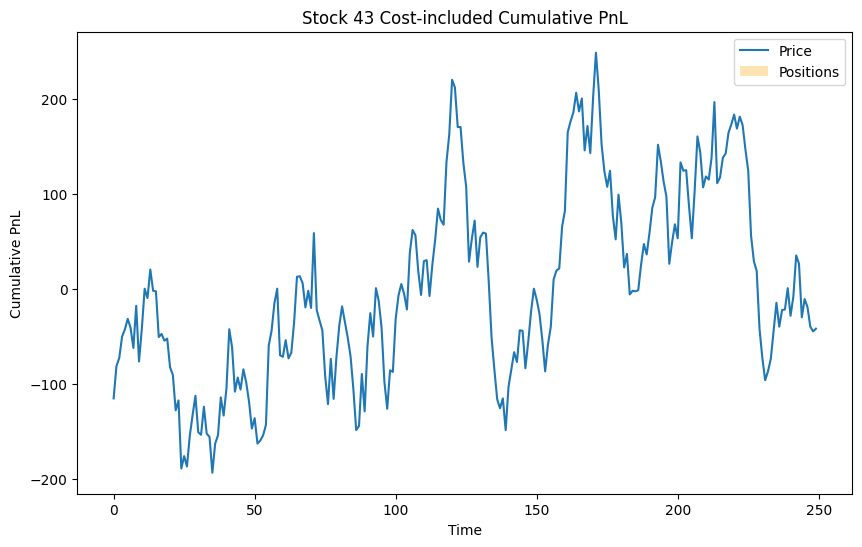

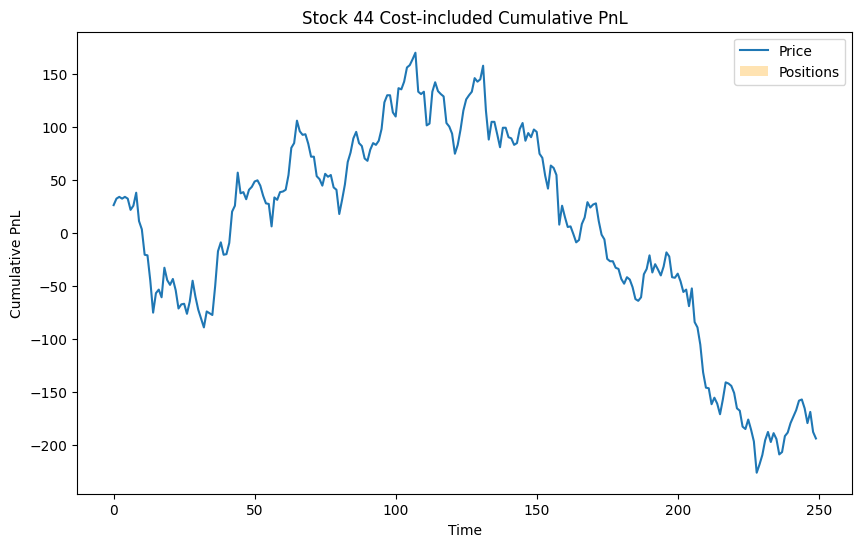

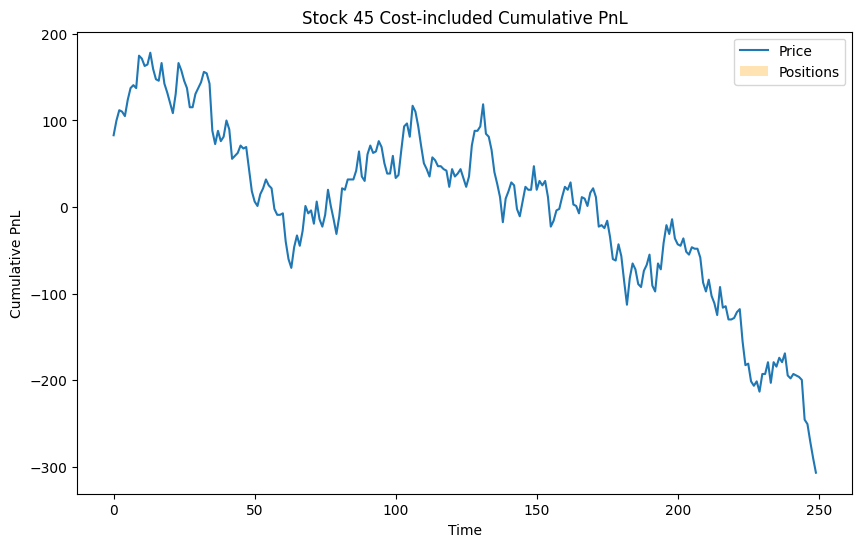

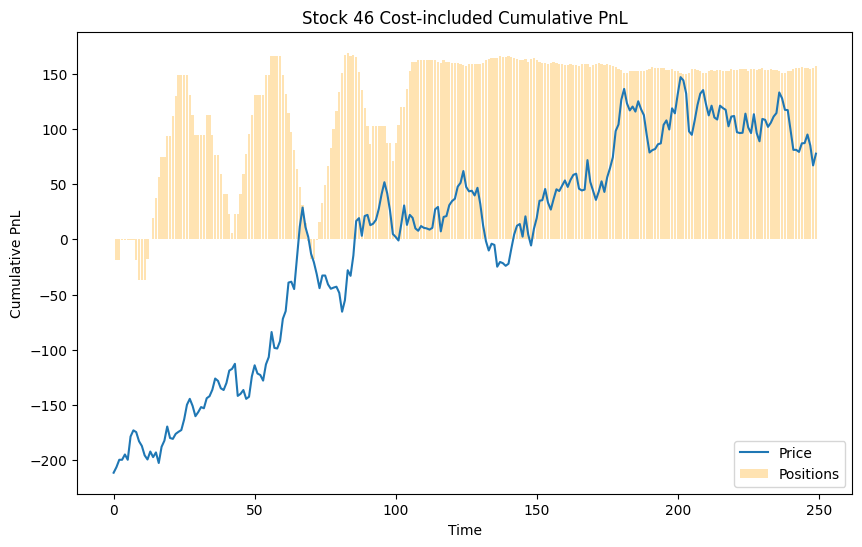

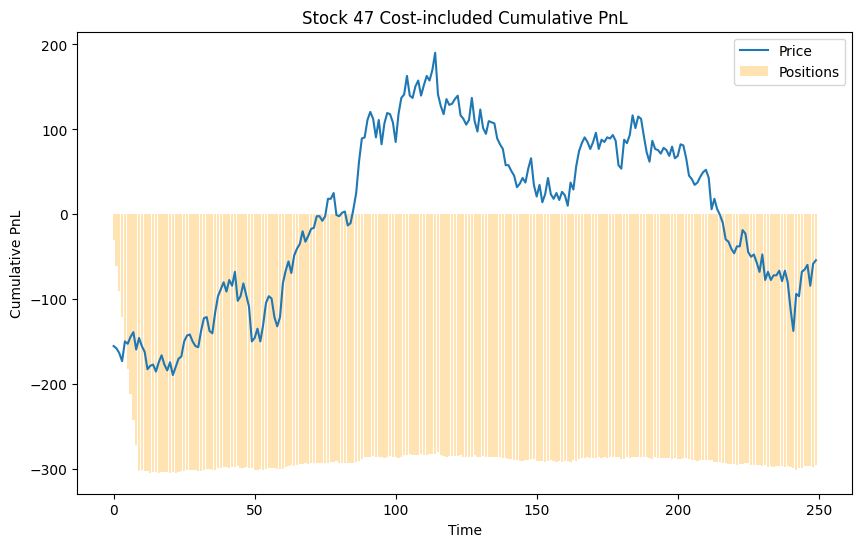

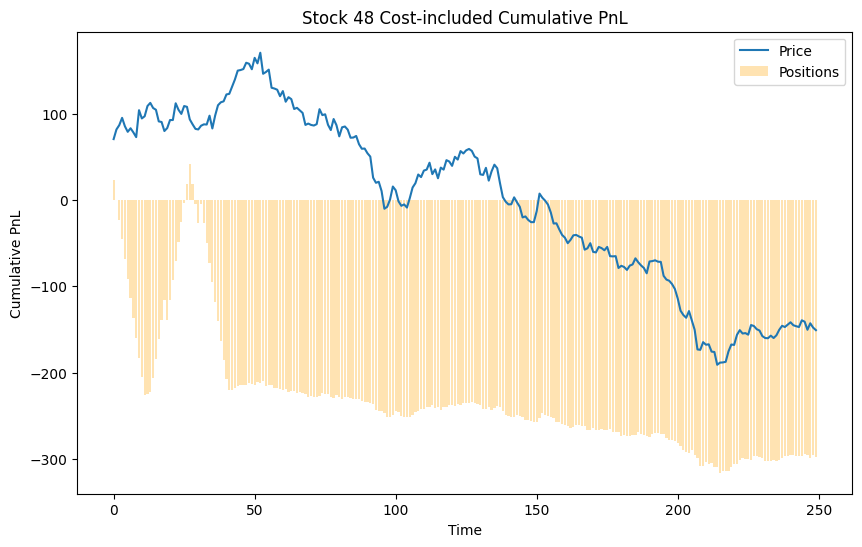

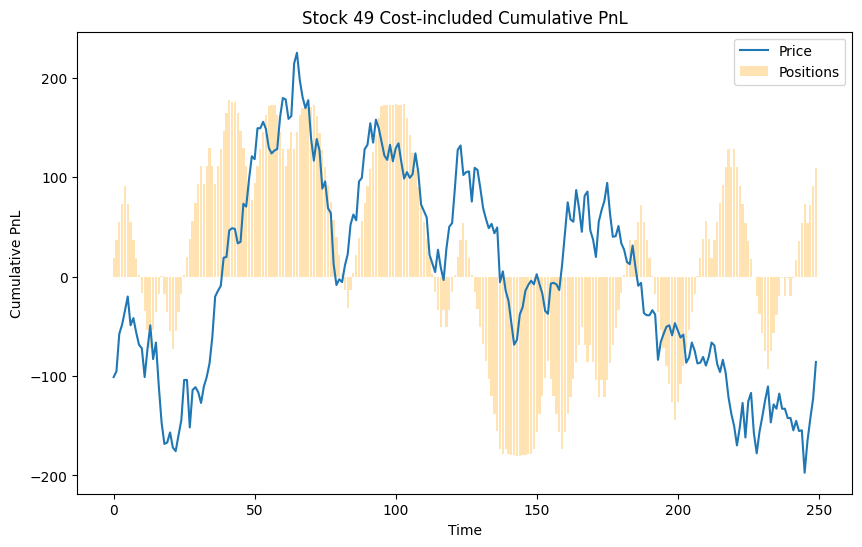

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [24]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()


# Graveyard

##### Difference

In [25]:
def build_difference_linear_regression(log_return_df, target_stock, features, test_start_date, train_length):

    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    # build models
    model = OLS(y, X).fit()

    return model

def inference_difference_linear_regression(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    X = log_return_df[[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[-1:]

    X = X.assign(const=1)
    
    pred_t1 = model.predict(X).values[0]

    return pred_t1

def predict_train_difference(log_return_df, model, target_stock, features, test_start_date, train_length):
    
    data = log_return_df[[f'{target_column}{target_stock[0]}_{target_stock[1]}']+[f'{_}_{target_stock[0]}' for _ in features]+[f'{_}_{target_stock[1]}' for _ in features]].iloc[test_start_date-train_length:test_start_date]
    data.dropna(inplace=True)

    y = data[f'{target_column}{target_stock[0]}_{target_stock[1]}']
    X = data.drop(columns=[f'{target_column}{target_stock[0]}_{target_stock[1]}'])
    X = X.assign(const=1)

    y_pred = model.predict(X)
    
    return y, y_pred

In [26]:
good_model_dict = defaultdict(dict)
model_accuracy_dict = defaultdict(dict)
model_features_dict = defaultdict(dict)

for i in tqdm(range(NUM_STOCKS)):
    for j in range(i+1, NUM_STOCKS):

        ma_model = build_difference_linear_regression(log_return_df, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)
        ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, FIRST_TEST_DATE, TRAIN_LENGTH)

        if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
            good_model_dict[i][j] = ma_model
            model_features_dict[i][j] = features
            model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'FIRST_TEST_DATE' is not defined

In [ ]:
def build_models_for_this_period(log_return_df, first_start_date):

    good_model_dict = defaultdict(dict)
    model_accuracy_dict = defaultdict(dict)
    model_features_dict = defaultdict(dict)

    for i in range(NUM_STOCKS):
        for j in range(i+1, NUM_STOCKS):
            
            ma_model = build_difference_linear_regression(log_return_df, [i, j], features, first_start_date, TRAIN_LENGTH)
            ma_y, ma_pred = predict_train_difference(log_return_df, ma_model, [i, j], features, first_start_date, TRAIN_LENGTH)

            if abs(ma_model.tvalues.values[0]) >= 2 or abs(ma_model.tvalues.values[len(features)]//2) >= 2:
                good_model_dict[i][j] = ma_model
                model_features_dict[i][j] = features
                model_accuracy_dict[i][j] = accuracy_score(np.sign(ma_y), np.sign(ma_pred))

    final_model_dict = defaultdict(dict)

    for stock_i in model_accuracy_dict:
        top_10 = sorted(model_accuracy_dict[stock_i].items(), key=lambda x: x[1], reverse=True)
        for stock_j, score in top_10:
            
            if stock_j in good_model_dict[stock_i]: # Todo: in future take average, or take average of votes?
                final_model_dict[stock_i][stock_j] = good_model_dict[stock_i][stock_j]

    return final_model_dict, model_features_dict

: 

In [ ]:
def getMyPosition(prcSoFar):
    
    global currentPos, final_model_dict, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date

    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
        first_start_date = prcSoFar.shape[1]

        final_model_dict, model_features_dict = build_models_for_this_period(log_return_df, first_start_date)

    #     if prcSoFar.shape[1] != 250: # TODO: hardcoded restore no-trade positions to 0
    #         for stock_i in old_model_dict:
    #             if stock_i not in final_model_dict:
    #                 currentPos[stock_i] = 0
    
        # old_model_dict = final_model_dict
    
    signal = np.zeros(50)

    # make predictions
    for stock_i in final_model_dict:
        for stock_j in final_model_dict[stock_i]:
            
            stock_i_j_prediction = inference_difference_linear_regression(log_return_df,
                                    final_model_dict[stock_i][stock_j],
                                    [stock_i,
                                    stock_j],
                                    model_features_dict[stock_i][stock_j],
                                    first_start_date,
                                    TRAIN_LENGTH)

            if stock_i_j_prediction > 0: 
                signal[stock_i] += 1
                signal[stock_j] -= 1
            elif stock_i_j_prediction < 0:
                signal[stock_i] -= 1
                signal[stock_j] += 1
     

    for stock_i in final_model_dict:
        if signal[stock_i] > 0:
            currentPos[stock_i] += 1000/prcSoFar[stock_i, -1]
        elif signal[stock_i] < -0:
            currentPos[stock_i] -= 1000/prcSoFar[stock_i, -1]
        
    return currentPos

: 